# MODULE 4 - FINAL PROJECT
\
**Student name:** Neha Patel\
**Student pace:** part time\
**Scheduled project review date/time:** 29 December 2020 | 4:00 pm EST\
**Instructor name:** James Irving

# Business Case

With an increasing sense of environment conservation and preservation, there has been immense research and development in the renewable energy sector. Renewable energy consumption is seen to grow exponentially each year for some of these sources. This leaves vast investing opportunities in the sector.

Analyzing the combined forecasts of energy consumption, cost, and returns helps the investors make an educated decision on the source of energy they want to invest in for both, long term and short term benefits.

This notebook shows a detailed analysis and comparison on the energy consumption of Hydroelectric power, Geothermal, Solar, Wind, and Wood Energy over the next 5 years

# Methodology

Each source of energy, Hydroelectric, Geothermal, Solar, Wind, and Wood, is analyzed individually using visualization and forecasts through Auto Arima method. A monthly frequency was set for the analysis.

The current scenarios and Forecasts are then compared.

The Data used for this project consist of renewable energy consumption beginning from 1973 till 2020. Since some of these sectors have just emerged a few years ago, they are relatively new and their consumption data do not date back to 1973. These values have been replaced with 0 and have not been included in the individual analysis.

# Libraries and Functions

## Installing and Importing Necessary Libraries

In [1]:
# !pip install tensorboard
# !pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pylab import rcParams
import seaborn as sns
import itertools
import statsmodels.api as sm
import missingno as ms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
# import warnings 
# warnings.filterwarnings('ignore')
import six
import joblib
import sys
sys.modules['sklearn.externals.six']=six
sys.modules['sklearn.externals.joblib']=joblib
import pmdarima as pm

## Functions

In [3]:
def seasonal_decomp(series):
    
    """
    gives the seasonal decomposition of a given series
    --------------------------------------------------
    Input:
    series (series)
    --------------------------------------------------
    Output:
    Seasonal decomposition plots
    """
    
    fig = plt.figure()  
    fig = seasonal_decompose(series).plot()  
    fig.set_size_inches(15, 12)

In [4]:
def test_stationarity(series, window, cutoff):
    
    """
    Tests stationarity using Dickey-Fuller Test
    -------------------------
    Input:
    series (series)
    window (int): Size of the moving window for rolling mean and rolling standard deviation calculation.
    cuttoff (float): cutoff for p-value to determine stationarity
    -------------------------
    Output:
    Displays if the series is stationary
    Displays the Dickey-Fuller Test Summary
    ROlling mean and Rolling Standard Deviation Plots
    """
    
    rolmean = series.rolling(window).mean()
    rolstd = series.rolling(window).std()
    
    fig = plt.figure(figsize = (12,8))
    ori = plt.plot(series, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Standard Deviation')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    print('Dicky-Fuller Test:')
    dftest = adfuller(series)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','#Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}']=value
    if dfoutput['p-value']<cutoff:
        print('The Series is likely Stattionary')
    else:
        print('The Series is likely Non-Stationary')
    print(dfoutput)
    

In [5]:
def shift(series,shift_no):
    
    """
    Shifts the time series to the given number of places
    -------------------
    Input:
    Series (Series)
    shift_no (int): the number of places that the series needs to shift
    """
    
    diff = series-series.shift(shift_no)
    diff = diff.dropna(inplace=False)
    return diff

In [6]:
def p_acf(series):
    
    """
    Builds the autocorrelation and partial correlation plots of a given series
    ---------------
    Input:
    Series (series)
    ---------------
    Output:
    statsmodel autocorrelation and partial correlation plot
    """
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, ax=ax1) 
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, ax=ax2)

In [7]:
def sarimax(df,p,d,q,P,D,Q,s):
    
    """Grid searches the best p,d,q based on the AIC values
    -----------------
    Input:
    df (DataFrame): Data required to model SARIMAX model
    p (range): AR component for ARIMA modelling
    d (range): difference component for ARIMA modelling
    q (range): MA component for ARIMA modelling
    P (range): AR component for SARIMA modelling
    D (range): difference component for SARIMA modelling
    Q (range): MA component for SARIMA modelling
    S (range): Seasonal component for SARIMA modelling
    ------------------
    Output:
    Best order and seasonal order corresponding the lowest AIC value
    """
    
    pdq = list(itertools.product(p,d,q))
    PDQs = [(x[0],x[1],x[2],s) for x in list(itertools.product(P,D,Q))]
    
    ans = []
    for comb in pdq:
        for combs in PDQs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df, order = comb, seasonal_order=combs,
                                                 enforce_stationarity=False, enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb,combs,output.aic])
                print(f'ARIMA {comb} x {combs}12 : AIC Calculated ={output.aic}')
            except:
                continue
    
    ans_df=pd.DataFrame(ans, columns=['pdq','PDQs','AIC'])
#     ans_df.AIC.plot(figsize=(15,6))
    
    return(ans_df.loc[ans_df['AIC'].idxmin])

In [8]:
def arima(df,arima,sarima):
    
    """Fits statsmodel SARIMAX model given order and seasonal order
    --------------
    Input:
    df (DataFrame): dataframe to be fit in the model
    arima (tuple): order for ARIMA model
    sarima (tuple):seasonal order for SARIMA model
    --------------
    Output
    Statsmodel SARIMAX model
    """
    
    arima = sm.tsa.statespace.SARIMAX(df, order = arima, seasonal_order=sarima,
                                    enforce_stationarity=False, enforce_invertibility=False)
    output = arima.fit()
    print(output.summary().tables[1])
    return output

In [9]:
def auto_arima(df,df_train, df_test,n_rows,seasonal=True, m=12, arima_kws={}):
    
    """Builds the best arima model from the p,q range of (0,5)
    -----------------
    Input:
    df (DataFrame)
    df_train (DataFrame): Train Split data
    df_test (DtataFrame): Test split data
    n_rows (integer): the value at which the train test split was made
    seasonal (bool): Seasonality to include or not
    m (int): seasonality
    -----------------
    Output:
    Best Sarima Model
    Best model summary
    prediction plot
    best model order and seasonal order
    """
    
    model = pm.auto_arima(df_train, seasonal=seasonal, m=m,**arima_kws)

    # make your forecasts
    forecasts = model.predict(df_test.shape[0])  # predict N steps into the future
    
    print('FORECAST VISUALIZATION'+'\n')

    # Visualize the forecasts (blue=train, green=forecasts)
    x = np.arange(df.shape[0])
    plt.plot(x[:n_rows], df_train, c='tab:cyan')
    plt.plot(x[n_rows:], df_test, c='tab:cyan')
    plt.plot(x[n_rows:], forecasts, c='darkslategrey')
    plt.xlabel('Time (Months)')
    plt.ylabel('Energy Consumption (Trillion BTU)')
    plt.show()
    
    # Model Summary
    print('\n\n','--'*20, '\n\n', 'MODEL SUMMARY','\n')
    
    display(model.summary())
    
    # Model Plot Diagnostics
    print('\n\n','--'*20, '\n\n', 'MODEL PLOT DIAGNOSTICS','\n')
    model.plot_diagnostics();
    
    #order and seasonal order
    print('\n\n','--'*20, '\n\n', 'ORDER, SEASONAL ORDER','\n')
    print(f'order = {model.order}')
    print(f'seasonal order = {model.seasonal_order}')
    
    return model.order, model.seasonal_order

In [10]:
def auto_arima(df,df_train, df_test,n_rows,seasonal=True, m=12):
    
    """Builds the best arima model from the p,q range of (0,5)
    -----------------
    Input:
    df (DataFrame)
    df_train (DataFrame): Train Split data
    df_test (DtataFrame): Test split data
    n_rows (integer): the value at which the train test split was made
    seasonal (bool): Seasonality to include or not
    m (int): seasonality
    -----------------
    Output:
    Best Sarima Model
    Best model summary
    prediction plot
    best model order and seasonal order
    """
    
    model = pm.auto_arima(df_train, seasonal=seasonal, m=m)

    # make your forecasts
    forecasts = model.predict(df_test.shape[0])  # predict N steps into the future
    
    print('FORECAST VISUALIZATION'+'\n')

    # Visualize the forecasts (blue=train, green=forecasts)
    x = np.arange(df.shape[0])
    plt.plot(x[:n_rows], df_train, c='tab:cyan')
    plt.plot(x[n_rows:], df_test, c='tab:cyan')
    plt.plot(x[n_rows:], forecasts, c='darkslategrey')
    plt.xlabel('Time (Months)')
    plt.ylabel('Energy Consumption (Trillion BTU)')
    plt.show()
    
    # Model Summary
    print('\n\n','--'*20, '\n\n', 'MODEL SUMMARY','\n')
    
    display(model.summary())
    
    # Model Plot Diagnostics
    print('\n\n','--'*20, '\n\n', 'MODEL PLOT DIAGNOSTICS','\n')
    model.plot_diagnostics();
    
    #order and seasonal order
    print('\n\n','--'*20, '\n\n', 'ORDER, SEASONAL ORDER','\n')
    print(f'order = {model.order}')
    print(f'seasonal order = {model.seasonal_order}')
    
    return model.order, model.seasonal_order

In [11]:
def forecast(model,df,forecast_start,steps=60,figsize=(15,8),color_conf='g',alpha_conf=0.3):
    
    """gives a specified step dynamic forecast for a statsmodel SARIMAX model
    --------------
    Input:
    model : Statsmodel SARIMAX model
    df (DataFrame)
    forecast_start (str): date in the format 'YYYY-MM-DD' where the forecast should start
    steps (int): steps into the future the forecasts should be created. Default is 60
    figsize (tuple): matplotlib figsize for the forecast output plot. default is (15,8)
    color_conf (str): color of the confidence interval. default is g
    alpha_conf (int)
    --------------
    Output:
    Matplotlib Forecast plot with confidence interval
    """
    
    forecast = model.get_forecast(steps=steps)
    ax = df.plot(label='Observed', figsize=figsize)
    forecast.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(forecast.conf_int().index,
                   forecast.conf_int().iloc[:,0],
                   forecast.conf_int().iloc[:,1],
                   color=color_conf,alpha=alpha_conf)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(forecast_start), forecast.predicted_mean.index[-1], alpha=.1, zorder=-1)
    plt.ylabel('Energy Consmption (Trillion BTU)')

    plt.legend()
    plt.show()

# The Data Set

In [12]:
df = pd.read_excel('Mod_4_proj_data.xlsx')
df

Month  Total Renewable Energy Production  \
0   1973-01-01                            403.981   
1   1973-02-01                            360.900   
2   1973-03-01                            400.161   
3   1973-04-01                            380.470   
4   1973-05-01                            392.141   
..         ...                                ...   
566 2020-03-01                            995.023   
567 2020-04-01                            919.439   
568 2020-05-01                           1040.212   
569 2020-06-01                           1060.066   
570 2020-07-01                           1003.547   

     Hydroelectric Power Consumption  Geothermal Energy Consumption  \
0                            272.703                          1.491   
1                            242.199                          1.363   
2                            268.810                          1.412   
3                            253.185                          1.649   
4                            260.770                          1.537   
..                               ...                            ...   
566                          202.739                         18.946   
567                          189.099                         17.553   
568                          268.273                         18.312   
569                          260.567                         17.424   
570                          236.338                         18.571   

    Solar Energy Consumption Wind Energy Consumption  Wood Energy Consumption  \
0              Not Available           Not Available                  129.630   
1              Not Available           Not Available                  117.194   
2              Not Available           Not Available                  129.763   
3              Not Available           Not Available                  125.462   
4              Not Available           Not Available                  129.624   
..                       ...                     ...                      ...   
566                   94.035                 268.416                  179.141   
567                  113.675                 268.881                  173.630   
568                  134.061                 256.554                  182.582   
569                  131.784                 274.458                  169.606   
570                  140.897                 206.661                  176.805   

     Waste Energy Consumption Biofuels Consumption  \
0                       0.157        Not Available   
1                       0.144        Not Available   
2                       0.176        Not Available   
3                       0.174        Not Available   
4                       0.210        Not Available   
..                        ...                  ...   
566                    38.061              162.492   
567                    35.323              112.394   
568                    35.810              145.906   
569                    32.542              166.727   
570                    34.490              179.397   

     Total Biomass Energy Consumption  Total Renewable Energy Consumption  
0                             129.787                             403.981  
1                             117.338                             360.900  
2                             129.938                             400.161  
3                             125.636                             380.470  
4                             129.834                             392.141  
..                                ...                                 ...  
566                           379.693                             963.830  
567                           321.348                             910.557  
568                           364.299                            1041.498  
569                           368.875                            1053.109  
570                           390.692                        

In [13]:
df['Month']=pd.to_datetime(df['Month'])
df.set_index(df['Month'],inplace = True)
df.drop('Month',axis=1,inplace=True)
df

Total Renewable Energy Production  \
Month                                           
1973-01-01                            403.981   
1973-02-01                            360.900   
1973-03-01                            400.161   
1973-04-01                            380.470   
1973-05-01                            392.141   
...                                       ...   
2020-03-01                            995.023   
2020-04-01                            919.439   
2020-05-01                           1040.212   
2020-06-01                           1060.066   
2020-07-01                           1003.547   

            Hydroelectric Power Consumption  Geothermal Energy Consumption  \
Month                                                                        
1973-01-01                          272.703                          1.491   
1973-02-01                          242.199                          1.363   
1973-03-01                          268.810                          1.412   
1973-04-01                          253.185                          1.649   
1973-05-01                          260.770                          1.537   
...                                     ...                            ...   
2020-03-01                          202.739                         18.946   
2020-04-01                          189.099                         17.553   
2020-05-01                          268.273                         18.312   
2020-06-01                          260.567                         17.424   
2020-07-01                          236.338                         18.571   

           Solar Energy Consumption Wind Energy Consumption  \
Month                                                         
1973-01-01            Not Available           Not Available   
1973-02-01            Not Available           Not Available   
1973-03-01            Not Available           Not Available   
1973-04-01            Not Available           Not Available   
1973-05-01            Not Available           Not Available   
...                             ...                     ...   
2020-03-01                   94.035                 268.416   
2020-04-01                  113.675                 268.881   
2020-05-01                  134.061                 256.554   
2020-06-01                  131.784                 274.458   
2020-07-01                  140.897                 206.661   

            Wood Energy Consumption  Waste Energy Consumption  \
Month                                                           
1973-01-01                  129.630                     0.157   
1973-02-01                  117.194                     0.144   
1973-03-01                  129.763                     0.176   
1973-04-01                  125.462                     0.174   
1973-05-01                  129.624                     0.210   
...                             ...                       ...   
2020-03-01                  179.141                    38.061   
2020-04-01                  173.630                    35.323   
2020-05-01                  182.582                    35.810   
2020-06-01                  169.606                    32.542   
2020-07-01                  176.805                    34.490   

           Biofuels Consumption  Total Biomass Energy Consumption  \
Month                                                               
1973-01-01        Not Available                           129.787   
1973-02-01        Not Available                           117.338   
1973-03-01        Not Available                           129.938   
1973-04-01        Not Available                           125.636   
1973-05-01        Not Available                           129.834   
...                         ...                               ...   
2020-03-01              162.492                           379.693   
2020-04-01              112.394                           321.348   
202

In [14]:
df_hyele = pd.DataFrame(df['Hydroelectric Power Consumption'])
df_geo = pd.DataFrame(df['Geothermal Energy Consumption'])
df_solar = pd.DataFrame(df['Solar Energy Consumption'])
df_wind = pd.DataFrame(df['Wind Energy Consumption'])
df_wood = pd.DataFrame(df['Wood Energy Consumption'])

In [15]:
df1=df.copy()
df1['Solar Energy Consumption']=df1['Solar Energy Consumption'].replace('Not Available',0)
df1['Wind Energy Consumption']=df1['Wind Energy Consumption'].replace('Not Available',0)

<AxesSubplot:xlabel='Month'>

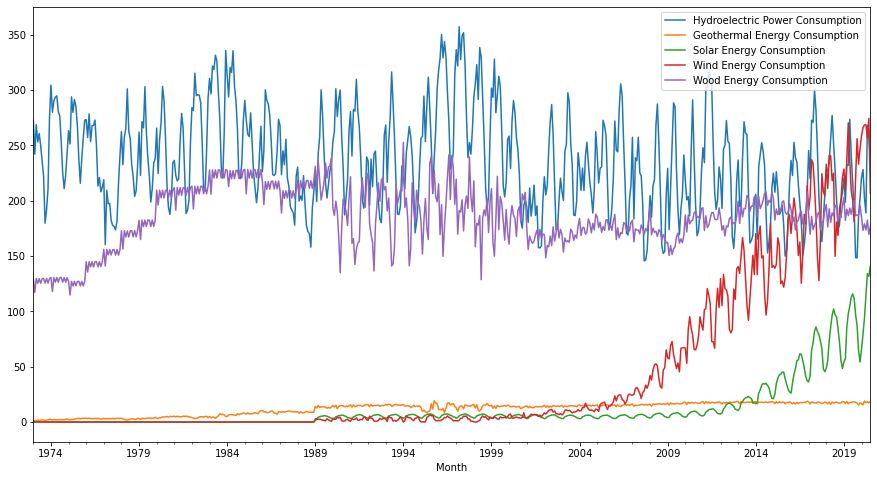

In [16]:
df1[['Hydroelectric Power Consumption','Geothermal Energy Consumption','Solar Energy Consumption',
          'Wind Energy Consumption','Wood Energy Consumption']].plot(figsize=(15,8))

## Yearly/Decade Analysis

In [17]:
df_yearly = df.copy()

In [18]:
df_yearly['Solar Energy Consumption']=df_yearly['Solar Energy Consumption'].replace('Not Available',0)
df_yearly['Wind Energy Consumption']=df_yearly['Wind Energy Consumption'].replace('Not Available',0)

In [19]:
df_yearly = df_yearly.copy().resample('Y').sum()
df_yearly['Year']=df_yearly.index
df_yearly.set_index(df_yearly['Year'],inplace = True)
df_yearly.drop('Year',axis=1,inplace=True)
df_yearly

Total Renewable Energy Production  \
Year                                            
1973-12-31                           4410.937   
1974-12-31                           4741.852   
1975-12-31                           4687.121   
1976-12-31                           4727.150   
1977-12-31                           4208.967   
1978-12-31                           5005.441   
1979-12-31                           5122.854   
1980-12-31                           5428.342   
1981-12-31                           5413.688   
1982-12-31                           5979.637   
1983-12-31                           6495.613   
1984-12-31                           6437.862   
1985-12-31                           6084.015   
1986-12-31                           6111.138   
1987-12-31                           5621.807   
1988-12-31                           5456.754   
1989-12-31                           6234.657   
1990-12-31                           6040.024   
1991-12-31                           6067.786   
1992-12-31                           5820.556   
1993-12-31                           6081.908   
1994-12-31                           5987.143   
1995-12-31                           6557.306   
1996-12-31                           7010.890   
1997-12-31                           7016.811   
1998-12-31                           6492.735   
1999-12-31                           6515.589   
2000-12-31                           6101.666   
2001-12-31                           5161.771   
2002-12-31                           5730.902   
2003-12-31                           5942.466   
2004-12-31                           6062.671   
2005-12-31                           6220.812   
2006-12-31                           6586.244   
2007-12-31                           6510.368   
2008-12-31                           7191.548   
2009-12-31                           7624.934   
2010-12-31                           8313.762   
2011-12-31                           9299.551   
2012-12-31                           8886.017   
2013-12-31                           9417.902   
2014-12-31                           9766.518   
2015-12-31                           9728.765   
2016-12-31                          10422.871   
2017-12-31                          11195.921   
2018-12-31                          11508.364   
2019-12-31                          11637.255   
2020-12-31                           7008.309   

            Hydroelectric Power Consumption  Geothermal Energy Consumption  \
Year                                                                         
1973-12-31                         2861.449                         20.422   
1974-12-31                         3176.580                         25.611   
1975-12-31                         3154.605                         33.780   
1976-12-31                         2976.265                         37.513   
1977-12-31                         2333.254                         37.383   
1978-12-31                         2936.983                         30.851   
1979-12-31                         2930.683                         40.259   
1980-12-31                         2900.143                         52.699   
1981-12-31                         2757.969                         59.436   
1982-12-31                         3265.558                         50.628   
1983-12-31                         3527.259                         63.911   
1984-12-31                         3385.812                         80.809   
1985-12-31                         2970.193                         97.420   
1986-12-31                         3071.179                        107.676   
1987-12-31                         2634.509                        112.268   
1988-12-31                         2334.266                        106.338   
1989-12-31                         2837.265                        161.541   
1990-12-31                         3046.389                        170.746   
1

Text(0, 0.5, 'Energy Consumption (Trillion BTU)')

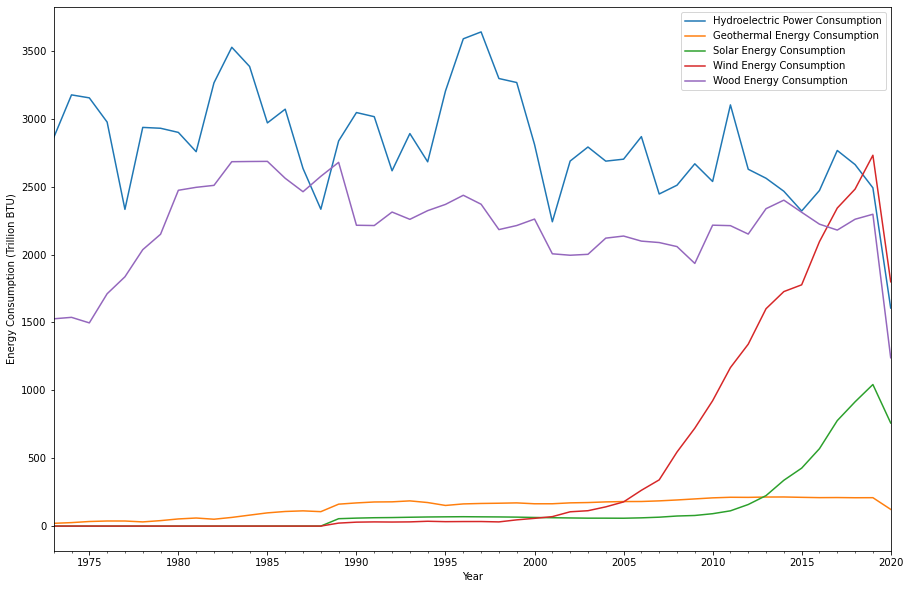

In [20]:
df_yearly[['Hydroelectric Power Consumption','Geothermal Energy Consumption','Solar Energy Consumption',
          'Wind Energy Consumption','Wood Energy Consumption']].plot(figsize=(15,10))
plt.ylabel('Energy Consumption (Trillion BTU)')

In [21]:
df_decade = df_yearly.copy()['1980':].resample('10A').sum()
df_decade

Total Renewable Energy Production  \
Year                                            
1980-12-31                           5428.342   
1990-12-31                          59875.195   
2000-12-31                          63652.390   
2010-12-31                          65345.478   
2020-12-31                          98871.473   

            Hydroelectric Power Consumption  Geothermal Energy Consumption  \
Year                                                                         
1980-12-31                         2900.143                         52.699   
1990-12-31                        29830.399                       1010.773   
2000-12-31                        31019.615                       1701.310   
2010-12-31                        26148.720                       1835.487   
2020-12-31                        25082.488                       2025.362   

            Solar Energy Consumption  Wind Energy Consumption  \
Year                                                            
1980-12-31                     0.000                    0.000   
1990-12-31                   113.749                   51.284   
2000-12-31                   659.331                  360.665   
2010-12-31                   666.401                 3402.315   
2020-12-31                  5325.650                19066.310   

            Wood Energy Consumption  Waste Energy Consumption  \
Year                                                            
1980-12-31                 2473.861                     1.639   
1990-12-31                25560.211                  2437.939   
2000-12-31                22949.077                  5159.904   
2010-12-31                20659.942                  4124.145   
2020-12-31                21618.097                  4628.441   

            Total Biomass Energy Consumption  \
Year                                           
1980-12-31                          2475.498   
1990-12-31                         28869.001   
2000-12-31                         29911.363   
2010-12-31                         33295.712   
2020-12-31                         46570.900   

            Total Renewable Energy Consumption  
Year                                            
1980-12-31                            5428.342  
1990-12-31                           59875.195  
2000-12-31                           63652.278  
2010-12-31                           65348.641  
2020-12-31                           98070.706

In [22]:
df_decade['Decade']=df_decade.index
df_decade.set_index(df_decade['Decade'],inplace = True)
df_decade.drop('Decade',axis=1,inplace=True)
df_decade

Total Renewable Energy Production  \
Decade                                          
1980-12-31                           5428.342   
1990-12-31                          59875.195   
2000-12-31                          63652.390   
2010-12-31                          65345.478   
2020-12-31                          98871.473   

            Hydroelectric Power Consumption  Geothermal Energy Consumption  \
Decade                                                                       
1980-12-31                         2900.143                         52.699   
1990-12-31                        29830.399                       1010.773   
2000-12-31                        31019.615                       1701.310   
2010-12-31                        26148.720                       1835.487   
2020-12-31                        25082.488                       2025.362   

            Solar Energy Consumption  Wind Energy Consumption  \
Decade                                                          
1980-12-31                     0.000                    0.000   
1990-12-31                   113.749                   51.284   
2000-12-31                   659.331                  360.665   
2010-12-31                   666.401                 3402.315   
2020-12-31                  5325.650                19066.310   

            Wood Energy Consumption  Waste Energy Consumption  \
Decade                                                          
1980-12-31                 2473.861                     1.639   
1990-12-31                25560.211                  2437.939   
2000-12-31                22949.077                  5159.904   
2010-12-31                20659.942                  4124.145   
2020-12-31                21618.097                  4628.441   

            Total Biomass Energy Consumption  \
Decade                                         
1980-12-31                          2475.498   
1990-12-31                         28869.001   
2000-12-31                         29911.363   
2010-12-31                         33295.712   
2020-12-31                         46570.900   

            Total Renewable Energy Consumption  
Decade                                          
1980-12-31                            5428.342  
1990-12-31                           59875.195  
2000-12-31                           63652.278  
2010-12-31                           65348.641  
2020-12-31                           98070.706

<AxesSubplot:xlabel='Decade'>

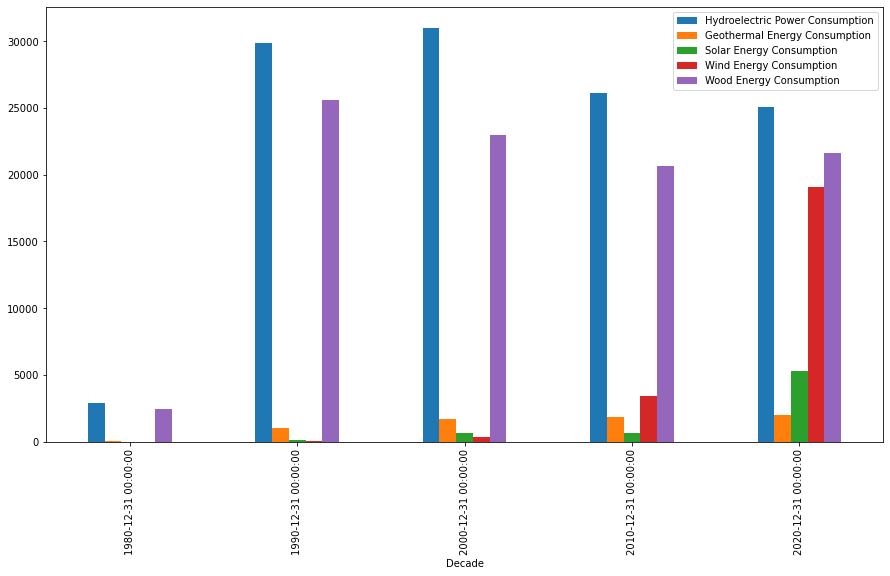

In [23]:
df_decade[['Hydroelectric Power Consumption','Geothermal Energy Consumption','Solar Energy Consumption',
          'Wind Energy Consumption','Wood Energy Consumption']].plot(kind = 'bar',figsize=(15,8))

<AxesSubplot:xlabel='Decade'>

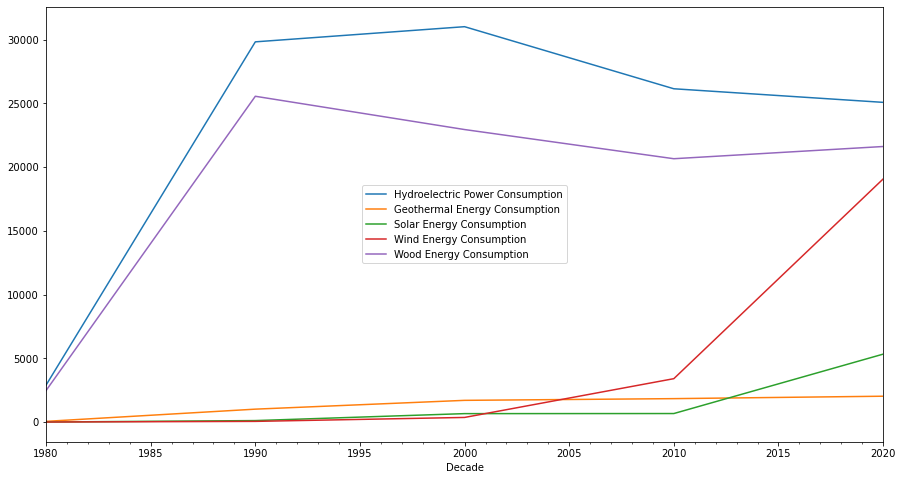

In [24]:
df_decade[['Hydroelectric Power Consumption','Geothermal Energy Consumption','Solar Energy Consumption',
          'Wind Energy Consumption','Wood Energy Consumption']].plot(figsize=(15,8))

# Hydroelectric Power Consumption

## Data Exploration

In [25]:
df_hyele

Hydroelectric Power Consumption
Month                                      
1973-01-01                          272.703
1973-02-01                          242.199
1973-03-01                          268.810
1973-04-01                          253.185
1973-05-01                          260.770
...                                     ...
2020-03-01                          202.739
2020-04-01                          189.099
2020-05-01                          268.273
2020-06-01                          260.567
2020-07-01                          236.338

[571 rows x 1 columns]

In [26]:
df_hyele.index

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='Month', length=571, freq=None)

In [27]:
df_hyele=df_hyele['Hydroelectric Power Consumption'].resample('MS').mean()

In [28]:
df_hyele.index

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='Month', length=571, freq='MS')

In [29]:
df_hyele.isna().sum()

0

<AxesSubplot:xlabel='Month'>

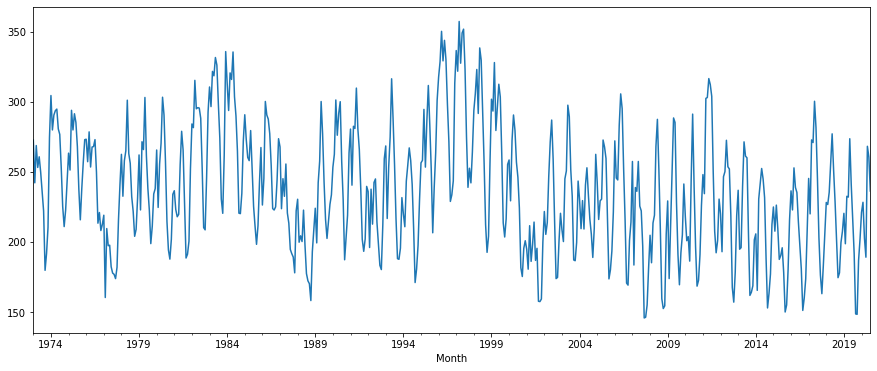

In [30]:
df_hyele.plot(figsize=(15,6))

In [31]:
df_hyele_train,df_hyele_test = df_hyele[:456],df_hyele[456:]

## Tuning p,d,q,s

<Figure size 432x288 with 0 Axes>

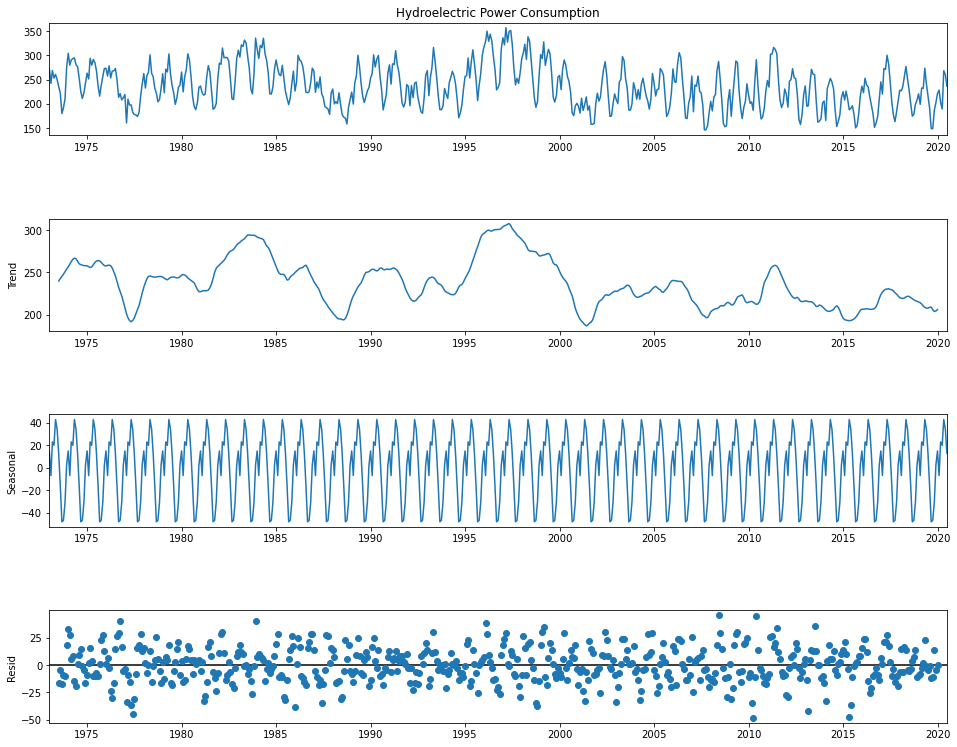

In [32]:
fig = plt.figure()  
fig = seasonal_decompose(df_hyele).plot()  
fig.set_size_inches(15, 12)

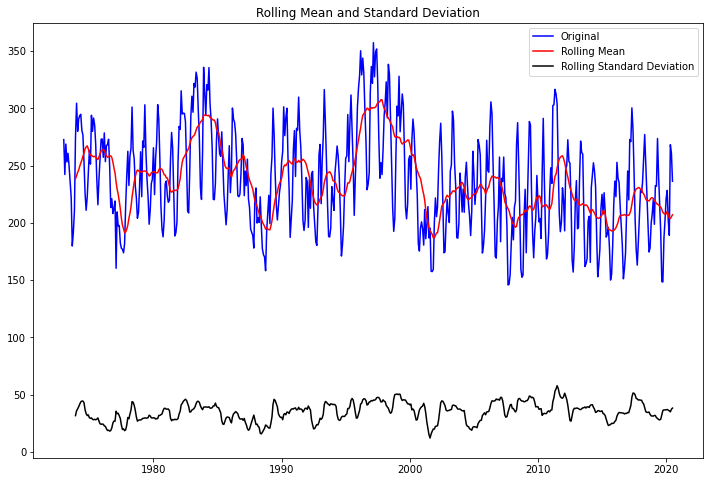

Dicky-Fuller Test:
The Series is likely Stattionary
Test Statistic         -4.132805
p-value                 0.000854
#Lags Used             14.000000
#Observations Used    556.000000
Critical Value 1%      -3.442166
Critical Value 5%      -2.866752
Critical Value 10%     -2.569546
dtype: float64


In [33]:
test_stationarity(df_hyele,12,0.05)

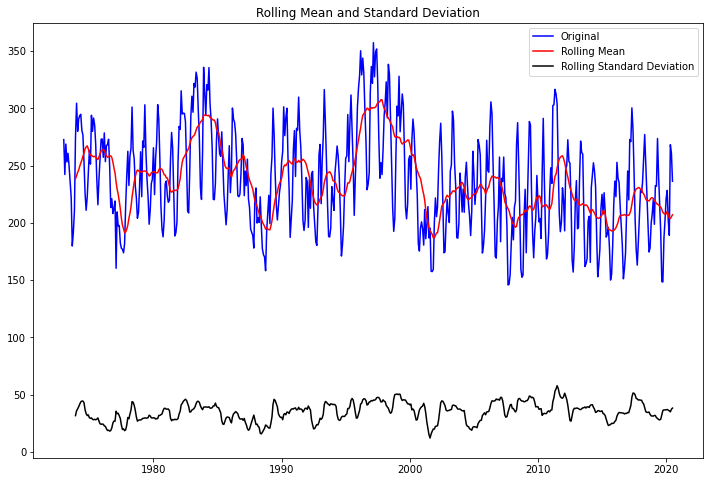

Dicky-Fuller Test:
The Series is likely Stattionary
Test Statistic         -4.132805
p-value                 0.000854
#Lags Used             14.000000
#Observations Used    556.000000
Critical Value 1%      -3.442166
Critical Value 5%      -2.866752
Critical Value 10%     -2.569546
dtype: float64


In [34]:
test_stationarity(df_hyele,12,0.01)

Therefore no further differencing to find out p parameter for ARIMA.

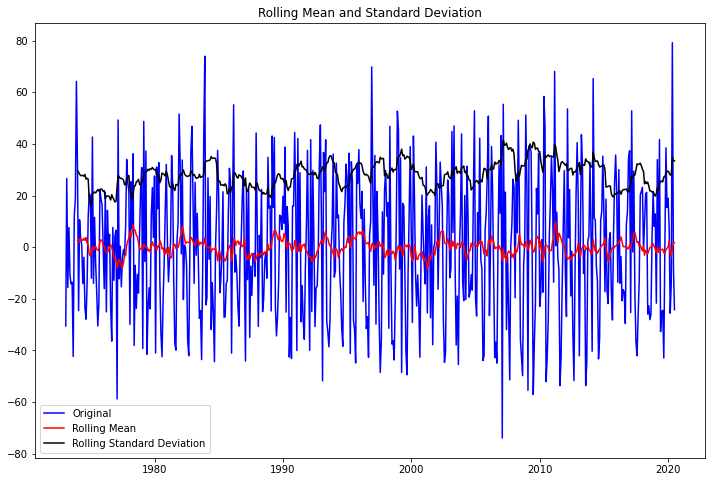

Dicky-Fuller Test:
The Series is likely Stattionary
Test Statistic       -6.801983e+00
p-value               2.225091e-09
#Lags Used            1.500000e+01
#Observations Used    5.540000e+02
Critical Value 1%    -3.442209e+00
Critical Value 5%    -2.866771e+00
Critical Value 10%   -2.569556e+00
dtype: float64


In [35]:
test_stationarity(df_hyele.diff().dropna(),12,0.05)

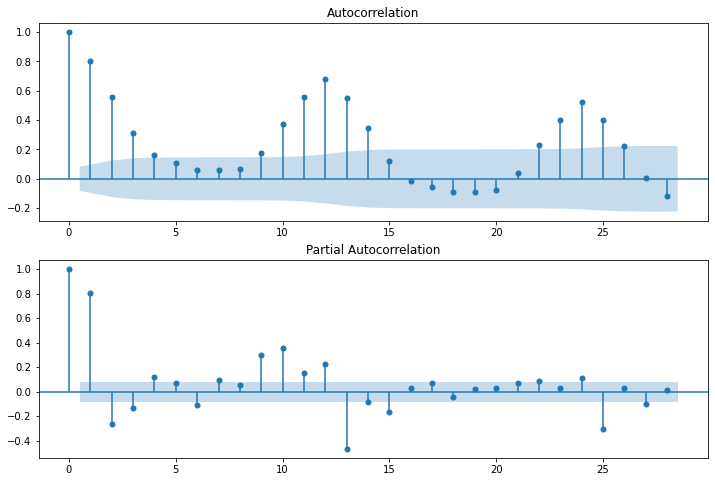

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_hyele, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_hyele, ax=ax2)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

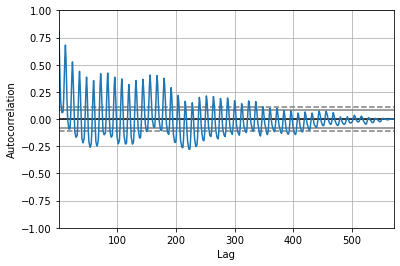

In [37]:
autocorrelation_plot(df_hyele)

## Auto Arima

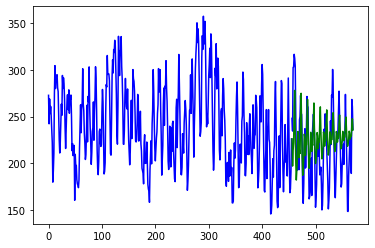

In [38]:
# Fit your model
model = pm.auto_arima(df_hyele_train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(df_hyele_test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(df_hyele.shape[0])
plt.plot(x[:456], df_hyele_train, c='blue')
plt.plot(x[456:], df_hyele_test, c='blue')
plt.plot(x[456:], forecasts, c='green')
plt.show()

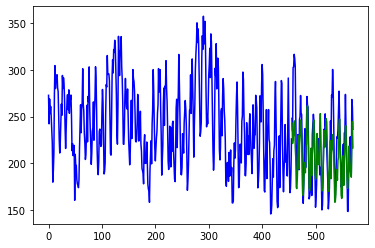

In [39]:
# Fit your model
model = pm.auto_arima(df_hyele_train, seasonal=True, m=60)

# make your forecasts
forecasts = model.predict(df_hyele_test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(df_hyele.shape[0])
plt.plot(x[:456], df_hyele_train, c='blue')
plt.plot(x[456:], df_hyele_test, c='blue')
plt.plot(x[456:], forecasts, c='green')
plt.show()

In [40]:
df_hyele_test.shape[0]

115

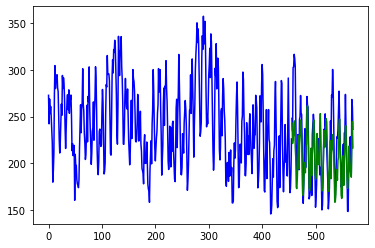

In [41]:
forecasts = model.predict(df_hyele_test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(df_hyele.shape[0])
plt.plot(x[:456], df_hyele_train, c='blue')
plt.plot(x[456:], df_hyele_test, c='blue')
plt.plot(x[456:], model.predict(115), c='green')
plt.show()

## Slicing to later data

In [42]:
df_hyele_later = df_hyele.loc['2002-01-01':]

In [43]:
df_hyele_train_ltr,df_hyele_test_ltr = df_hyele_later[:178],df_hyele_later[178:]

In [44]:
# Fit your model
model = pm.auto_arima(df_hyele_train_ltr, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(df_hyele_test_ltr.shape[0])  # predict N steps into the future

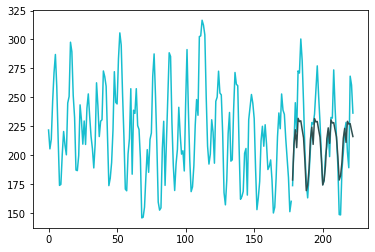

In [45]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(df_hyele_later.shape[0])
plt.plot(x[:178], df_hyele_train_ltr, c='tab:cyan')
plt.plot(x[178:], df_hyele_test_ltr, c='tab:cyan')
plt.plot(x[178:], forecasts, c='darkslategrey')
plt.show()

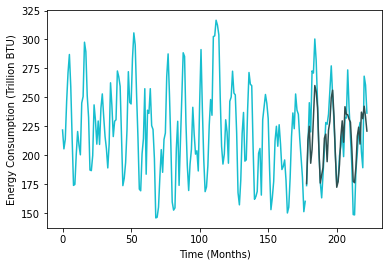

In [46]:
# Fit your model
model = pm.auto_arima(df_hyele_train_ltr, seasonal=True, m=48)

# make your forecasts
forecasts = model.predict(df_hyele_test_ltr.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(df_hyele_later.shape[0])
plt.plot(x[:178], df_hyele_train_ltr, c='tab:cyan')
plt.plot(x[178:], df_hyele_test_ltr, c='tab:cyan')
plt.plot(x[178:], forecasts, c='darkslategrey')
plt.xlabel('Time (Months)')
plt.ylabel('Energy Consumption (Trillion BTU)')
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  178
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 48)   Log Likelihood                -800.458
Date:                              Sat, 09 Jan 2021   AIC                           1610.916
Time:                                      12:38:50   BIC                           1626.825
Sample:                                           0   HQIC                          1617.368
                                              - 178                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.1134      5.235      0.977      0.329      -5.147      15.373
ar.L1          0.7549      0.050     15.071      0.000       0.657       0.853
ar.S.L48       0.9021      0.091      9.882      0.000       0.723       1.081
ma.S.L48      -0.5031      0.230     -2.188      0.029      -0.954      -0.052
sigma2       366.9713     44.096      8.322      0.000     280.546     453.397
===================================================================================
Ljung-Box (L1) (Q):                   2.99   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.08   Prob(JB):                         0.97
Heteroskedasticity (H):               0.97   Skew:                            -0.01
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

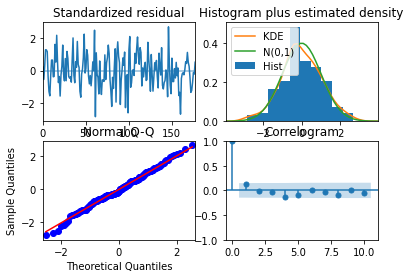

In [47]:
display(model.summary())
model.plot_diagnostics();

In [48]:
model.order

(1, 0, 0)

In [49]:
model.seasonal_order

(1, 0, 1, 48)

In [50]:
best_model = arima(df_hyele_later,model.order,model.seasonal_order)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7374      0.050     14.803      0.000       0.640       0.835
ar.S.L48       0.9652      0.011     87.358      0.000       0.943       0.987
ma.S.L48      -1.0000      0.089    -11.212      0.000      -1.175      -0.825
sigma2       253.1549      0.000   7.19e+05      0.000     253.154     253.156


In [51]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:      Hydroelectric Power Consumption   No. Observations:                  223
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 48)   Log Likelihood                -764.969
Date:                              Sat, 09 Jan 2021   AIC                           1537.938
Time:                                      12:38:55   BIC                           1550.574
Sample:                                  01-01-2002   HQIC                          1543.064
                                       - 07-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7374      0.050     14.803      0.000       0.640       0.835
ar.S.L48       0.9652      0.011     87.358      0.000       0.943       0.987
ma.S.L48      -1.0000      0.089    -11.212      0.000      -1.175      -0.825
sigma2       253.1549      0.000   7.19e+05      0.000     253.154     253.156
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 8.68
Prob(Q):                              0.93   Prob(JB):                         0.01
Heteroskedasticity (H):               0.85   Skew:                            -0.22
Prob(H) (two-sided):                  0.54   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.16e+22. Standard errors may be unstable.
"""

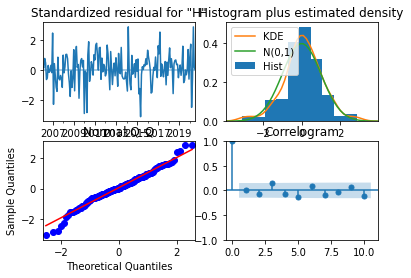

In [52]:
best_model.plot_diagnostics();

In [53]:
forecast_5 = best_model.get_forecast(steps=60)
forecast_5.predicted_mean
forecast_5.conf_int()

lower Hydroelectric Power Consumption  \
2020-08-01                             170.401687   
2020-09-01                             125.533654   
2020-10-01                             112.309260   
2020-11-01                             121.067441   
2020-12-01                             159.352638   
2021-01-01                             170.330233   
2021-02-01                             134.897405   
2021-03-01                             157.962402   
2021-04-01                             175.942374   
2021-05-01                             207.796425   
2021-06-01                             199.250410   
2021-07-01                             175.602421   
2021-08-01                             135.161563   
2021-09-01                             104.174139   
2021-10-01                             108.559913   
2021-11-01                             120.096281   
2021-12-01                             147.274140   
2022-01-01                             160.075991   
2022-02-01                             140.558527   
2022-03-01                             154.181882   
2022-04-01                             169.269058   
2022-05-01                             193.387963   
2022-06-01                             196.796589   
2022-07-01                             167.769612   
2022-08-01                             132.298522   
2022-09-01                             100.530316   
2022-10-01                             103.371479   
2022-11-01                             123.466860   
2022-12-01                             143.337206   
2023-01-01                             157.269657   
2023-02-01                             132.883808   
2023-03-01                             172.766315   
2023-04-01                             170.437013   
2023-05-01                             188.989300   
2023-06-01                             175.760324   
2023-07-01                             163.149794   
2023-08-01                             138.137390   
2023-09-01                             100.215353   
2023-10-01                              98.254376   
2023-11-01                             114.648500   
2023-12-01                             141.981553   
2024-01-01                             148.546597   
2024-02-01                             134.927382   
2024-03-01                             154.604630   
2024-04-01                             147.724809   
2024-05-01                             179.376609   
2024-06-01                             177.118449   
2024-07-01                             159.620964   
2024-08-01                             134.006605   
2024-09-01                             102.152231   
2024-10-01                              95.678488   
2024-11-01                             107.917870   
2024-12-01                             147.260149   
2025-01-01                             159.415726   
2025-02-01                             126.262203   
2025-03-01                             149.237137   
2025-04-01                             167.086401   
2025-05-01                             198.179616   
2025-06-01                             190.179985   
2025-07-01                             167.534530   

            upper Hydroelectric Power Consumption  
2020-08-01                             240.131300  
2020-09-01                             212.172856  
2020-10-01                             206.883368  
2020-11-01                             219.689015  
2020-12-01                             260.107043  
2021-01-01                             272.225759  
2021-02-01                             237.408154  
2021-03-01                             260.806172  
2021-04-01                             278.966792  
2021-05-01                             310.918949  
2021-06-01                             302.426246  
2021-07-01                             278.807237  
2021-08-01                             238.382136  
2021-09-01                             207.403279 

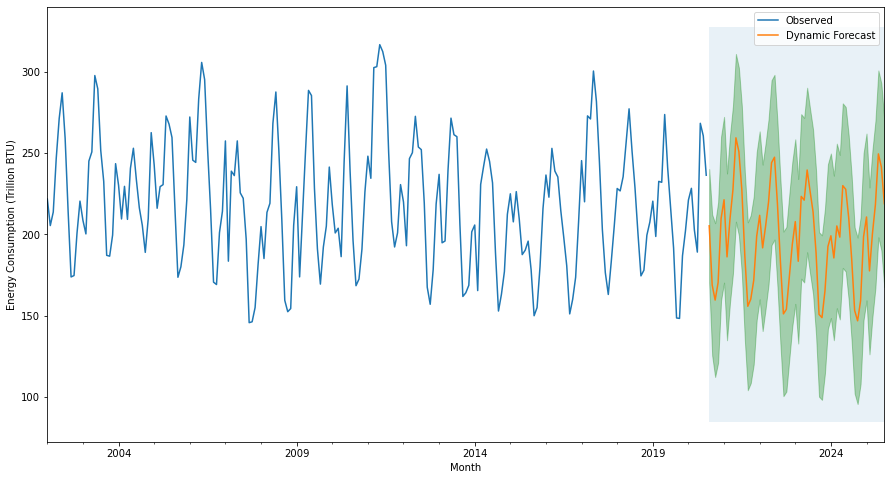

In [54]:
ax = df_hyele_later.plot(label='Observed', figsize=(15,8))
forecast_5.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(forecast_5.conf_int().index,
               forecast_5.conf_int().iloc[:,0],
               forecast_5.conf_int().iloc[:,1],
               color='g',alpha=0.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-08-01'), forecast_5.predicted_mean.index[-1], alpha=.1, zorder=-1)

plt.ylabel('Energy Consumption (Trillion BTU)')
plt.legend()
plt.show()

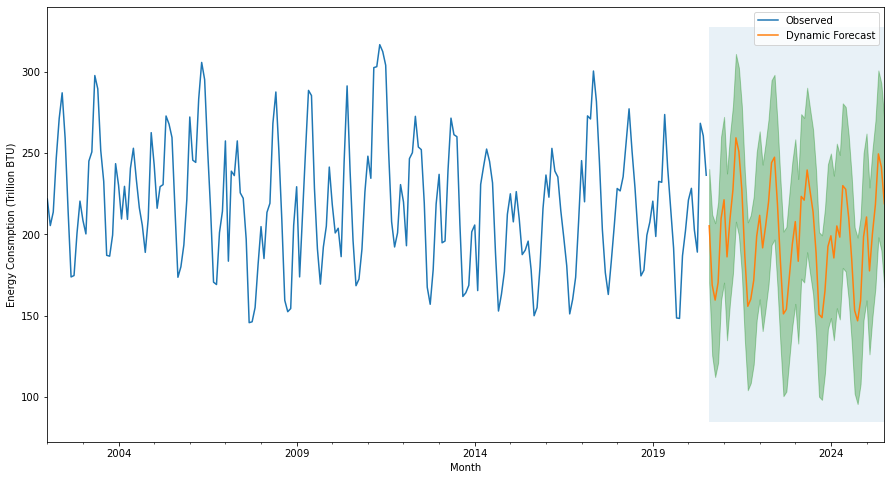

In [55]:
forecast(best_model,df_hyele_later,forecast_start='2020-08-01')

# Geothermal Energy Consumption

## Data Exploration

In [56]:
df_geo

Geothermal Energy Consumption
Month                                    
1973-01-01                          1.491
1973-02-01                          1.363
1973-03-01                          1.412
1973-04-01                          1.649
1973-05-01                          1.537
...                                   ...
2020-03-01                         18.946
2020-04-01                         17.553
2020-05-01                         18.312
2020-06-01                         17.424
2020-07-01                         18.571

[571 rows x 1 columns]

In [57]:
df_geo.isna().sum()

Geothermal Energy Consumption    0
dtype: int64

In [58]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 571 entries, 1973-01-01 to 2020-07-01
Data columns (total 1 columns):
Geothermal Energy Consumption    571 non-null float64
dtypes: float64(1)
memory usage: 8.9 KB


<AxesSubplot:xlabel='Month'>

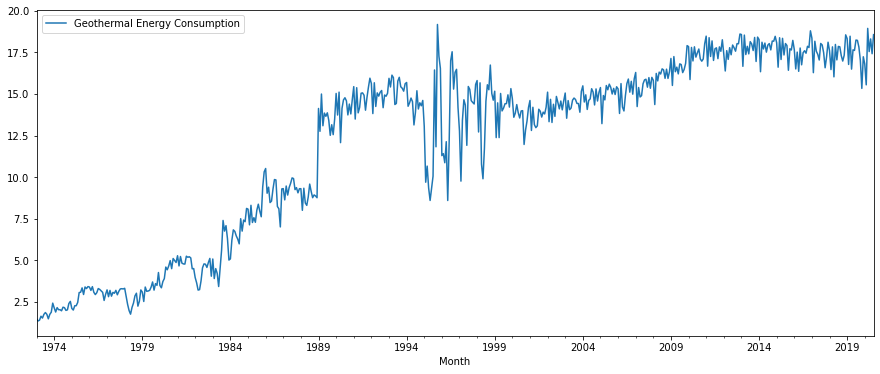

In [59]:
df_geo.plot(figsize=(15,6))

<Figure size 432x288 with 0 Axes>

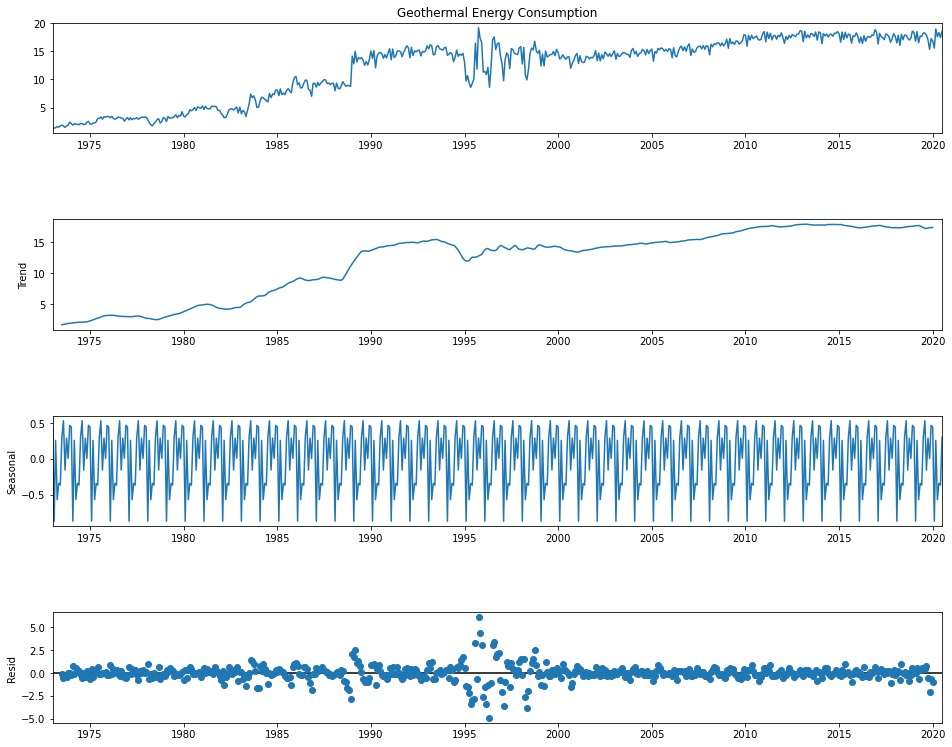

In [60]:
seasonal_decomp(df_geo['Geothermal Energy Consumption'])

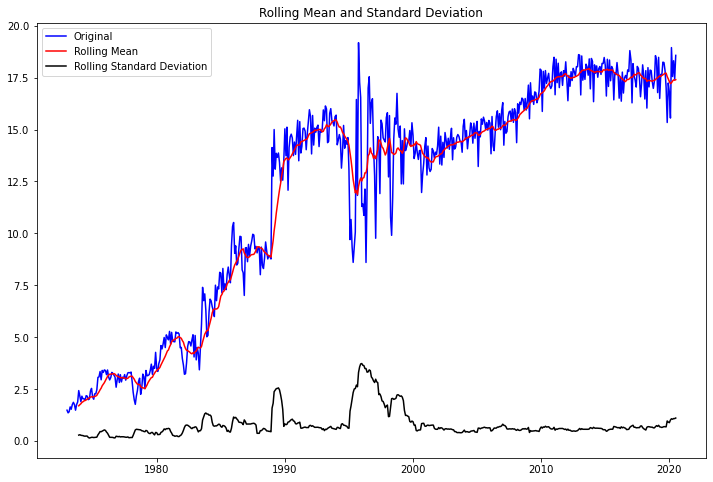

Dicky-Fuller Test:
The Series is likely Non-Stationary
Test Statistic         -1.698244
p-value                 0.432017
#Lags Used             17.000000
#Observations Used    553.000000
Critical Value 1%      -3.442230
Critical Value 5%      -2.866781
Critical Value 10%     -2.569561
dtype: float64


In [61]:
test_stationarity(df_geo['Geothermal Energy Consumption'],12,0.05)

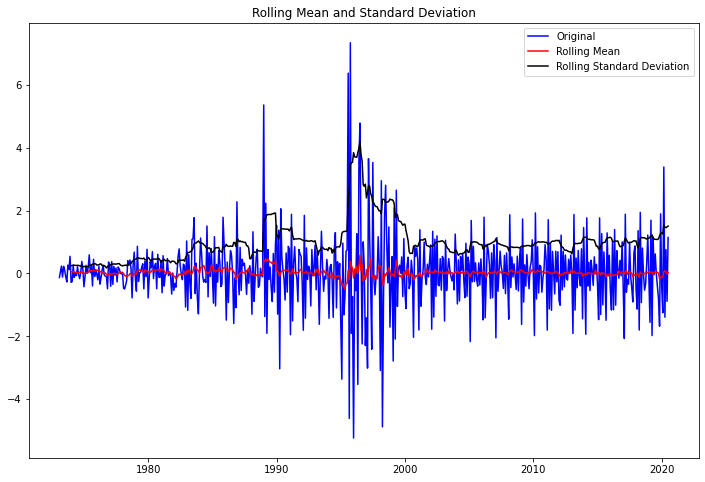

Dicky-Fuller Test:
The Series is likely Stattionary
Test Statistic       -6.276453e+00
p-value               3.889951e-08
#Lags Used            1.600000e+01
#Observations Used    5.530000e+02
Critical Value 1%    -3.442230e+00
Critical Value 5%    -2.866781e+00
Critical Value 10%   -2.569561e+00
dtype: float64


In [62]:
diff_1 = df_geo['Geothermal Energy Consumption']-df_geo['Geothermal Energy Consumption'].shift(1)
diff_1 = diff_1.dropna(inplace=False)
test_stationarity(diff_1,12,0.05)

<Figure size 432x288 with 0 Axes>

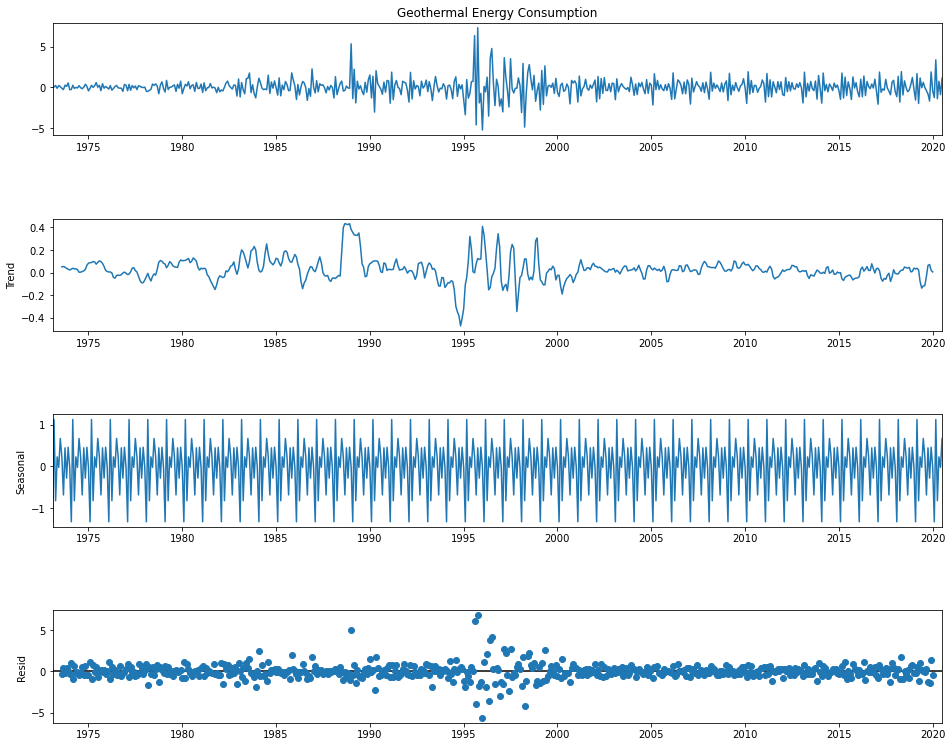

In [63]:
seasonal_decomp(diff_1)

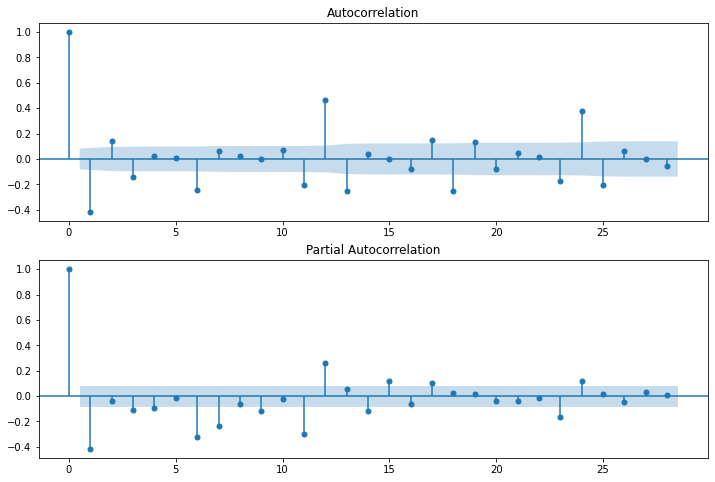

In [64]:
p_acf(diff_1)

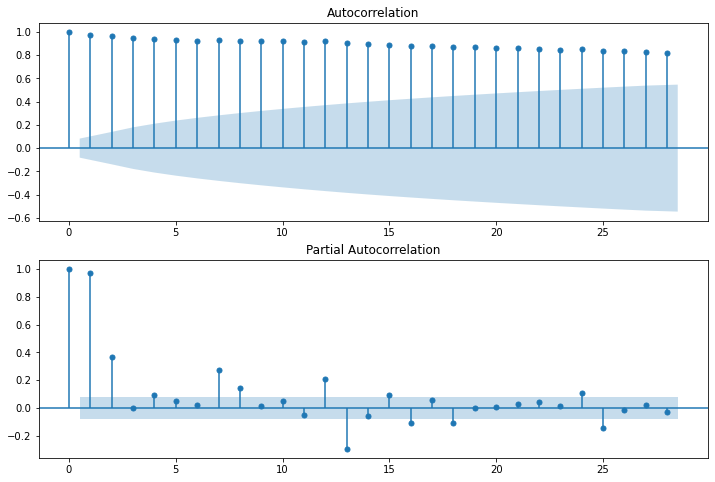

In [65]:
p_acf(df_geo['Geothermal Energy Consumption'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

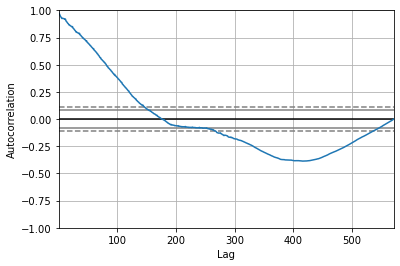

In [66]:
autocorrelation_plot(df_geo)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

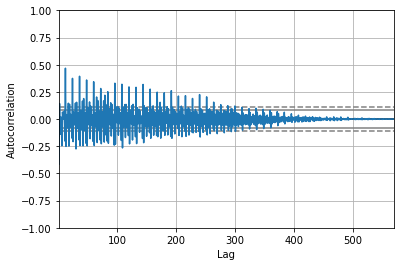

In [67]:
autocorrelation_plot(diff_1)

In [68]:
df_geo_train,df_geo_test = df_geo[:456],df_geo[456:]

## Base Model

In [69]:
df_geo_later = df_geo.loc['2002-01-01':]

<Figure size 432x288 with 0 Axes>

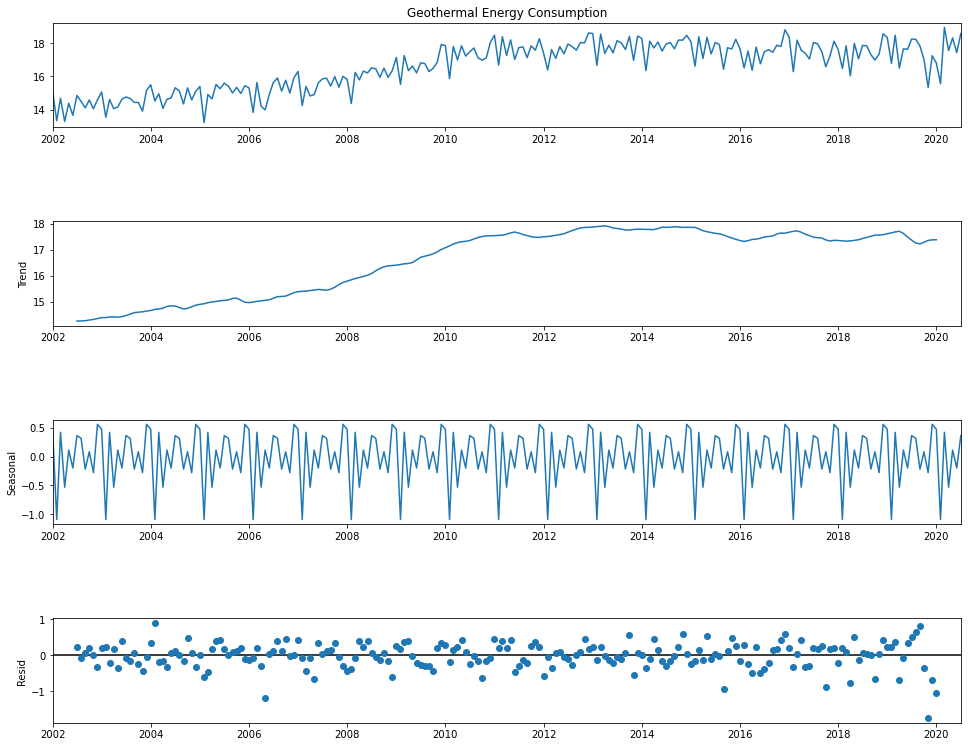

In [70]:
seasonal_decomp(df_geo_later['Geothermal Energy Consumption'])

In [71]:
df_geo_train_ltr,df_geo_test_ltr = df_geo_later[:178],df_geo_later[178:]

FORECAST VISUALIZATION



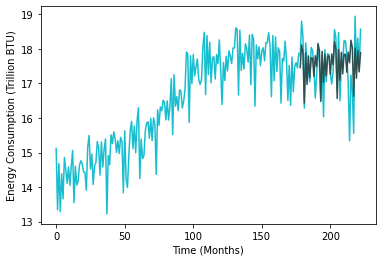



 ---------------------------------------- 

 MODEL SUMMARY 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  178
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -83.889
Date:                            Sat, 09 Jan 2021   AIC                            177.778
Time:                                    12:39:48   BIC                            193.658
Sample:                                         0   HQIC                           184.218
                                            - 178                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1965      0.108      1.823      0.068      -0.015       0.408
ma.L1         -0.8013      0.073    -10.946      0.000      -0.945      -0.658
ar.S.L12       0.9890      0.009    105.071      0.000       0.971       1.007
ma.S.L12      -0.7648      0.084     -9.078      0.000      -0.930      -0.600
sigma2         0.1325      0.014      9.287      0.000       0.105       0.160
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                16.16
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.57
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



 ---------------------------------------- 

 MODEL PLOT DIAGNOSTICS 



 ---------------------------------------- 

 ORDER, SEASONAL ORDER 

order = (1, 1, 1)
seasonal order = (1, 0, 1, 12)


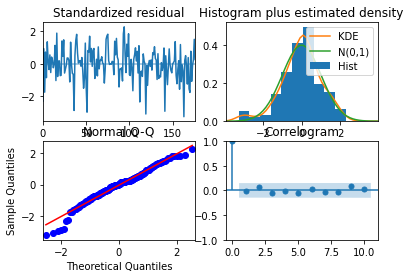

In [72]:
order_geo, seasonal_order_geo = auto_arima(df_geo_later,df_geo_train_ltr,df_geo_test_ltr,n_rows=178)

In [73]:
best_model_geo = arima(df_geo_later,order_geo,seasonal_order_geo)

C:\Users\19035\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\19035\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3647      0.092      3.973      0.000       0.185       0.545
ma.L1         -0.8719      0.047    -18.417      0.000      -0.965      -0.779
ar.S.L12       1.0041      0.016     64.390      0.000       0.974       1.035
ma.S.L12      -0.7647      0.070    -10.970      0.000      -0.901      -0.628
sigma2         0.1796      0.012     14.435      0.000       0.155       0.204


In [74]:
best_model_geo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:      Geothermal Energy Consumption   No. Observations:                  223
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -122.177
Date:                            Sat, 09 Jan 2021   AIC                            254.354
Time:                                    12:39:49   BIC                            271.042
Sample:                                01-01-2002   HQIC                           261.101
                                     - 07-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3647      0.092      3.973      0.000       0.185       0.545
ma.L1         -0.8719      0.047    -18.417      0.000      -0.965      -0.779
ar.S.L12       1.0041      0.016     64.390      0.000       0.974       1.035
ma.S.L12      -0.7647      0.070    -10.970      0.000      -0.901      -0.628
sigma2         0.1796      0.012     14.435      0.000       0.155       0.204
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               109.63
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

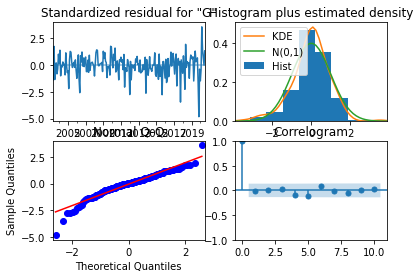

In [75]:
best_model_geo.plot_diagnostics();

In [76]:
df_geo_test_ltr.index[-1]

Timestamp('2020-07-01 00:00:00')

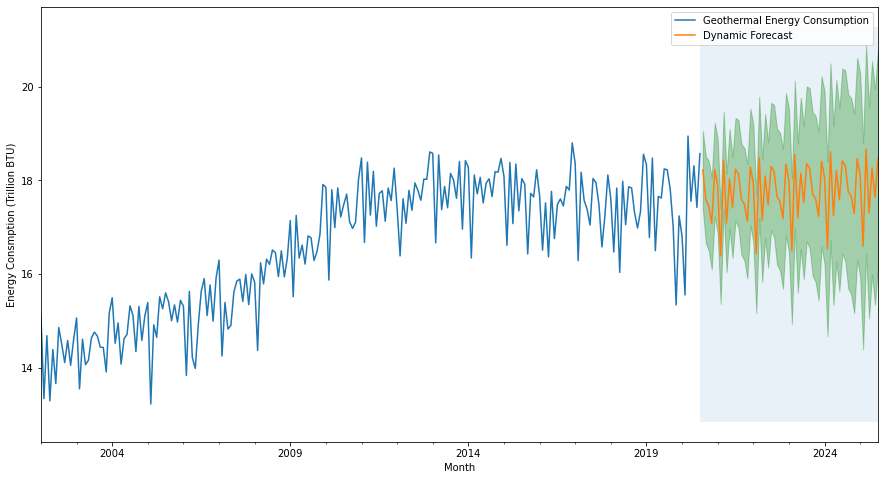

In [77]:
forecast(best_model_geo,df_geo_later,forecast_start=df_geo_test_ltr.index[-1])

# Solar Energy Consumption

## Data Exploration

In [78]:
df_solar = pd.DataFrame(df['Solar Energy Consumption'])

In [79]:
df_solar

Solar Energy Consumption
Month                              
1973-01-01            Not Available
1973-02-01            Not Available
1973-03-01            Not Available
1973-04-01            Not Available
1973-05-01            Not Available
...                             ...
2020-03-01                   94.035
2020-04-01                  113.675
2020-05-01                  134.061
2020-06-01                  131.784
2020-07-01                  140.897

[571 rows x 1 columns]

In [80]:
df_solar.isna().sum()

Solar Energy Consumption    0
dtype: int64

In [81]:
df_solar['Solar Energy Consumption']=df_solar['Solar Energy Consumption'].replace('Not Available',0)

<AxesSubplot:xlabel='Month'>

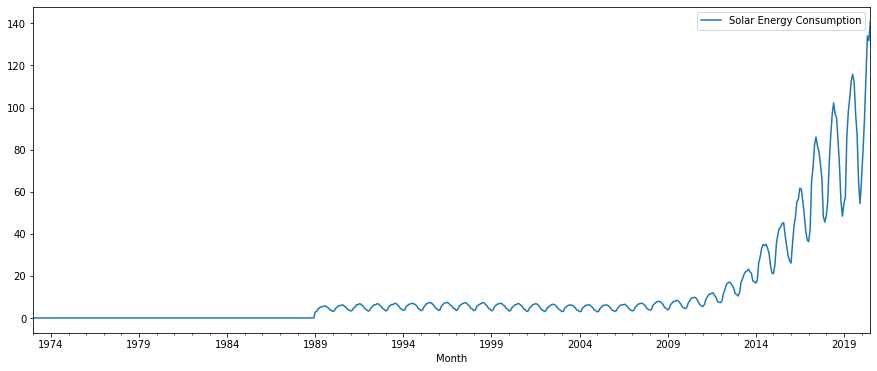

In [82]:
df_solar.plot(figsize=(15,6))

In [83]:
df_solar=df_solar.loc[df_solar['Solar Energy Consumption']!=0]

<AxesSubplot:xlabel='Month'>

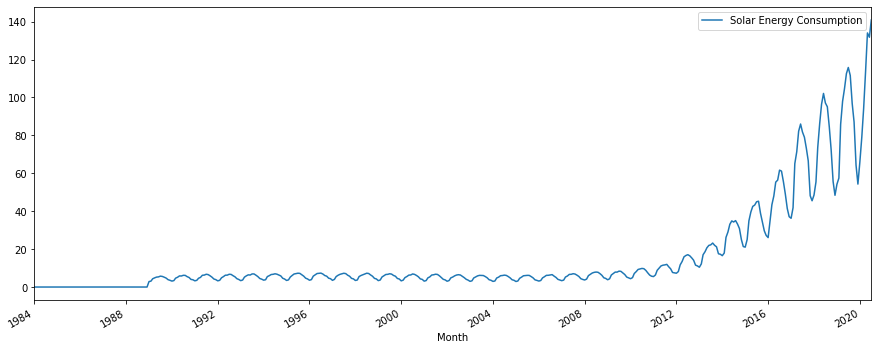

In [84]:
df_solar.plot(figsize=(15,6))

In [85]:
df_solar['Solar Energy Consumption'].dtype

dtype('float64')

In [86]:
df_solar['Solar Energy Consumption'] = df_solar['Solar Energy Consumption'].astype('float')

C:\Users\19035\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
df_solar

Solar Energy Consumption
Month                               
1984-01-01                    -0.001
1984-02-01                     0.001
1984-03-01                     0.002
1984-04-01                     0.003
1984-05-01                     0.007
...                              ...
2020-03-01                    94.035
2020-04-01                   113.675
2020-05-01                   134.061
2020-06-01                   131.784
2020-07-01                   140.897

[438 rows x 1 columns]

In [88]:
df_solar=df_solar['Solar Energy Consumption'].resample('MS').mean().bfill()

In [89]:
df_solar.index

DatetimeIndex(['1984-01-01', '1984-02-01', '1984-03-01', '1984-04-01',
               '1984-05-01', '1984-06-01', '1984-07-01', '1984-08-01',
               '1984-09-01', '1984-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='Month', length=439, freq='MS')

In [90]:
df_solar[df_solar.isna()]

Series([], Freq: MS, Name: Solar Energy Consumption, dtype: float64)

<Figure size 432x288 with 0 Axes>

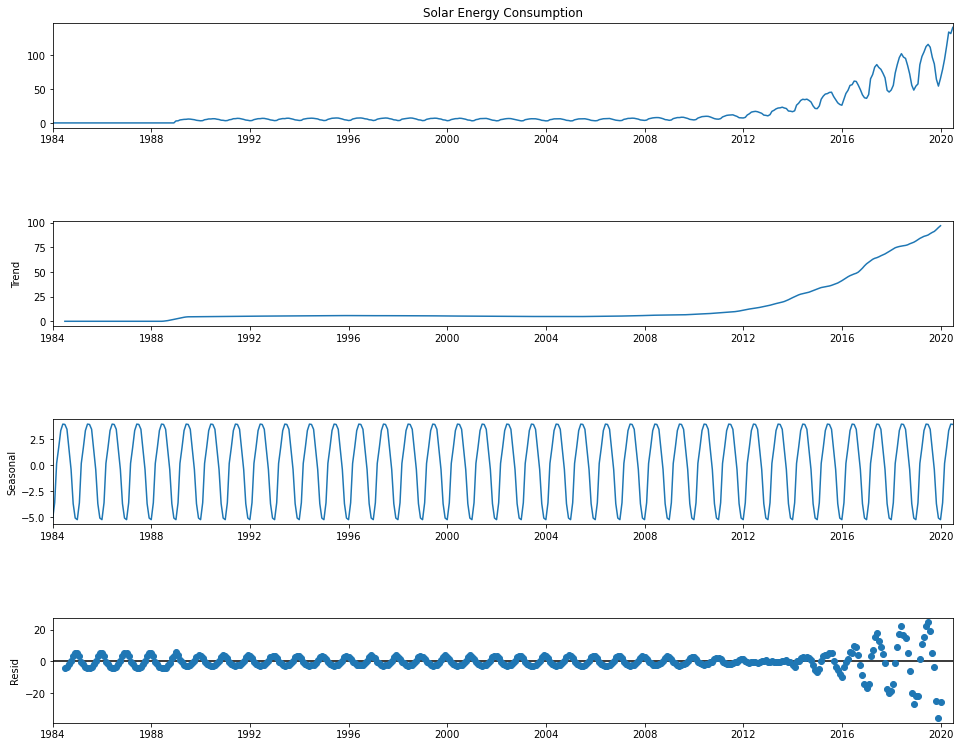

In [91]:
seasonal_decomp(df_solar)

## Selecting p,d,q

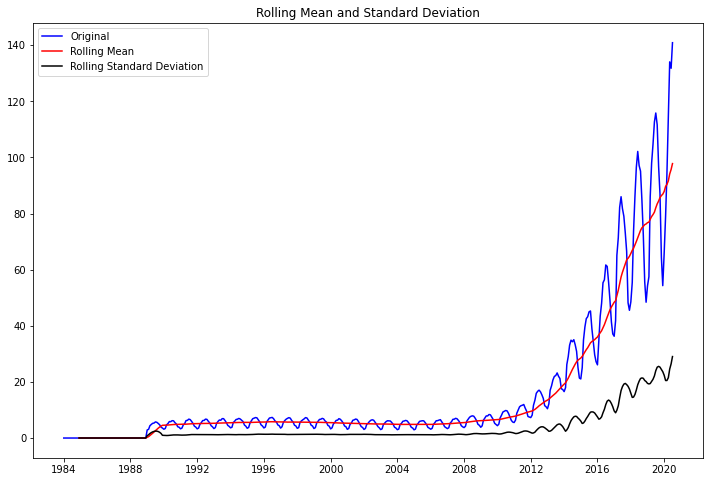

Dicky-Fuller Test:
The Series is likely Non-Stationary
Test Statistic          2.980273
p-value                 1.000000
#Lags Used             15.000000
#Observations Used    423.000000
Critical Value 1%      -3.445904
Critical Value 5%      -2.868397
Critical Value 10%     -2.570423
dtype: float64


In [92]:
test_stationarity(df_solar,12,0.05)

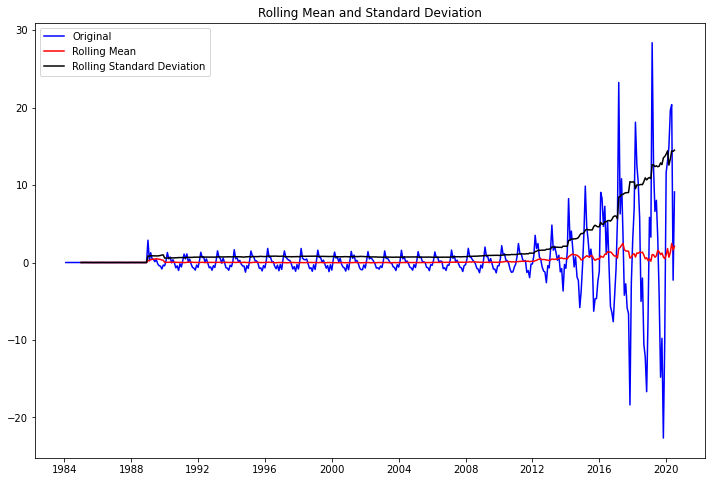

Dicky-Fuller Test:
The Series is likely Non-Stationary
Test Statistic         -0.426347
p-value                 0.905606
#Lags Used             14.000000
#Observations Used    423.000000
Critical Value 1%      -3.445904
Critical Value 5%      -2.868397
Critical Value 10%     -2.570423
dtype: float64


In [93]:
diff_1_solar=shift(df_solar,1)
test_stationarity(diff_1_solar,12,0.05)

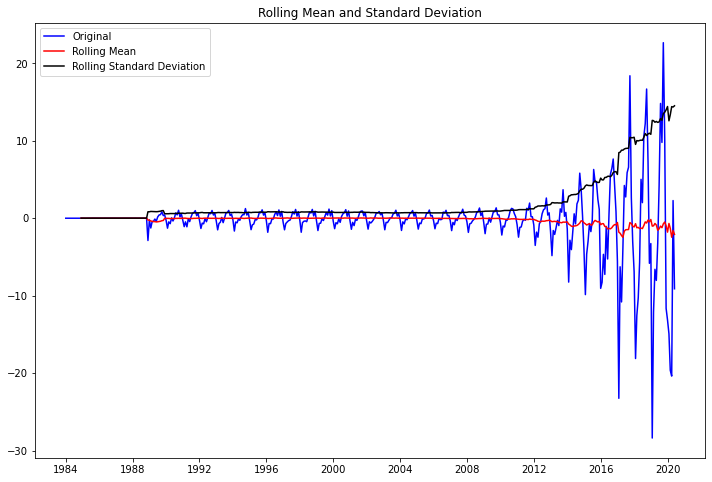

Dicky-Fuller Test:
The Series is likely Non-Stationary
Test Statistic         -0.426347
p-value                 0.905606
#Lags Used             14.000000
#Observations Used    423.000000
Critical Value 1%      -3.445904
Critical Value 5%      -2.868397
Critical Value 10%     -2.570423
dtype: float64


In [94]:
diff_2_solar=shift(df_solar,-1)
test_stationarity(diff_2_solar,12,0.05)

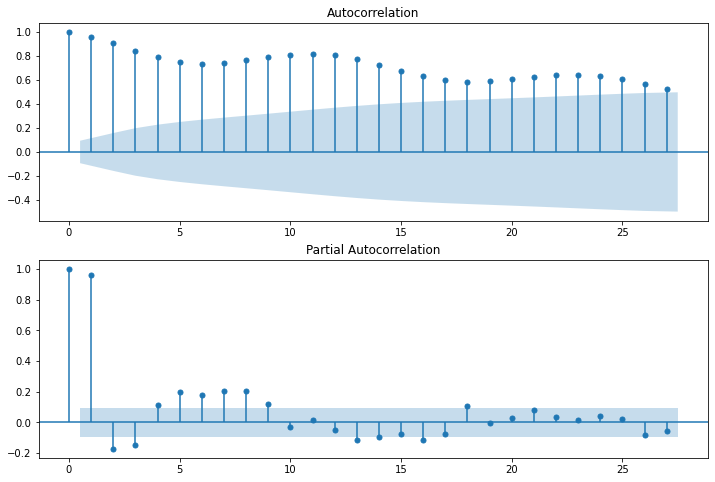

In [95]:
p_acf(df_solar)

## Base Model - Auto Arima

In [96]:
df_solar.shape[0]

439

In [97]:
df_solar_train,df_solar_test = df_solar[:410],df_solar[410:]

FORECAST VISUALIZATION



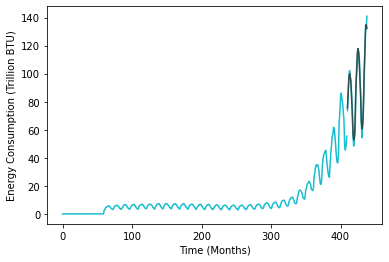



 ---------------------------------------- 

 MODEL SUMMARY 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  410
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -616.093
Date:                              Sat, 09 Jan 2021   AIC                           1246.185
Time:                                      12:40:47   BIC                           1274.073
Sample:                                           0   HQIC                          1257.233
                                              - 410                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7335      0.013    135.346      0.000       1.708       1.759
ar.L2         -0.9953      0.011    -87.715      0.000      -1.018      -0.973
ma.L1         -1.7468      0.043    -40.236      0.000      -1.832      -1.662
ma.L2          0.9218      0.039     23.497      0.000       0.845       0.999
ar.S.L12      -0.0965      0.088     -1.098      0.272      -0.269       0.076
ma.S.L12      -0.4600      0.077     -5.980      0.000      -0.611      -0.309
sigma2         1.2777      0.050     25.453      0.000       1.179       1.376
===================================================================================
Ljung-Box (L1) (Q):                   4.93   Jarque-Bera (JB):             37052.40
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              13.85   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



 ---------------------------------------- 

 MODEL PLOT DIAGNOSTICS 



 ---------------------------------------- 

 ORDER, SEASONAL ORDER 

order = (2, 1, 2)
seasonal order = (1, 1, 1, 12)


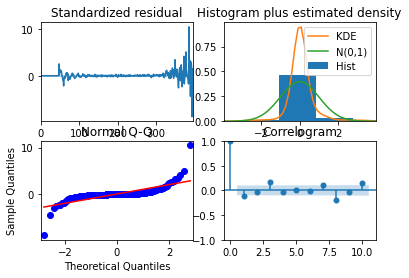

In [98]:
order_solar, seasonal_order_solar = auto_arima(df_solar,df_solar_train,df_solar_test,n_rows=410)

In [99]:
best_model_solar = arima(df_solar,order_solar,seasonal_order_solar)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.015    -27.934      0.000      -0.447      -0.388
ar.L2         -0.9138      0.011    -80.102      0.000      -0.936      -0.891
ma.L1          0.2052      0.015     13.609      0.000       0.176       0.235
ma.L2          0.8752      0.018     49.229      0.000       0.840       0.910
ar.S.L12      -0.8819      0.085    -10.350      0.000      -1.049      -0.715
ma.S.L12       0.6978      0.098      7.122      0.000       0.506       0.890
sigma2         3.2893      0.074     44.554      0.000       3.145       3.434


In [100]:
best_model_solar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:             Solar Energy Consumption   No. Observations:                  439
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -832.612
Date:                              Sat, 09 Jan 2021   AIC                           1679.224
Time:                                      12:40:49   BIC                           1707.354
Sample:                                  01-01-1984   HQIC                          1690.352
                                       - 07-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.015    -27.934      0.000      -0.447      -0.388
ar.L2         -0.9138      0.011    -80.102      0.000      -0.936      -0.891
ma.L1          0.2052      0.015     13.609      0.000       0.176       0.235
ma.L2          0.8752      0.018     49.229      0.000       0.840       0.910
ar.S.L12      -0.8819      0.085    -10.350      0.000      -1.049      -0.715
ma.S.L12       0.6978      0.098      7.122      0.000       0.506       0.890
sigma2         3.2893      0.074     44.554      0.000       3.145       3.434
===================================================================================
Ljung-Box (L1) (Q):                   4.29   Jarque-Bera (JB):              6037.47
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):              50.86   Skew:                             1.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

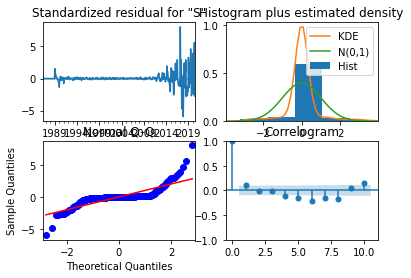

In [101]:
best_model_solar.plot_diagnostics();

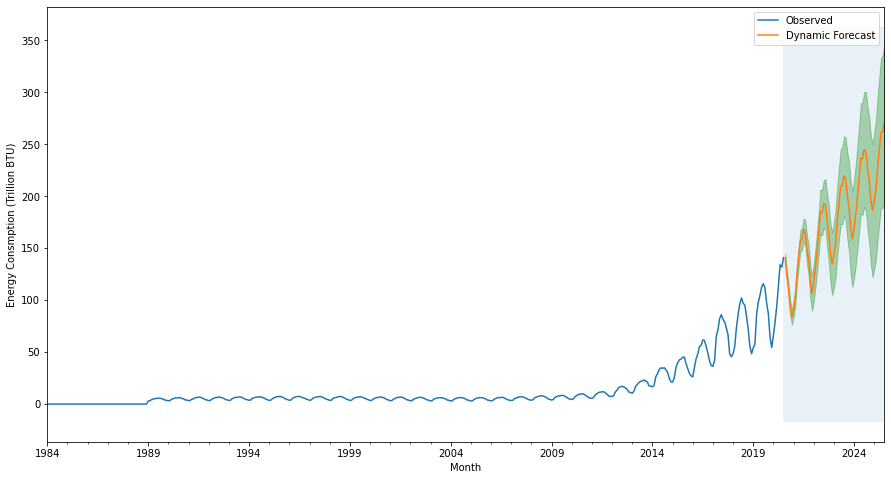

In [102]:
forecast(best_model_solar,df_solar,forecast_start=df_solar_test.index[-1])

# Wind Energy Consumption

## Data Exploration

In [103]:
df_wind

Wind Energy Consumption
Month                             
1973-01-01           Not Available
1973-02-01           Not Available
1973-03-01           Not Available
1973-04-01           Not Available
1973-05-01           Not Available
...                            ...
2020-03-01                 268.416
2020-04-01                 268.881
2020-05-01                 256.554
2020-06-01                 274.458
2020-07-01                 206.661

[571 rows x 1 columns]

In [104]:
df_wind['Wind Energy Consumption']=df_wind['Wind Energy Consumption'].replace('Not Available',0)

<AxesSubplot:xlabel='Month'>

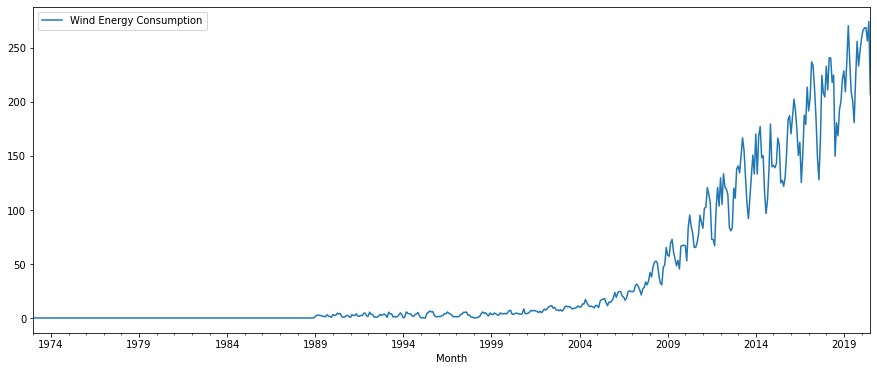

In [105]:
df_wind.plot(figsize=(15,6))

<Figure size 432x288 with 0 Axes>

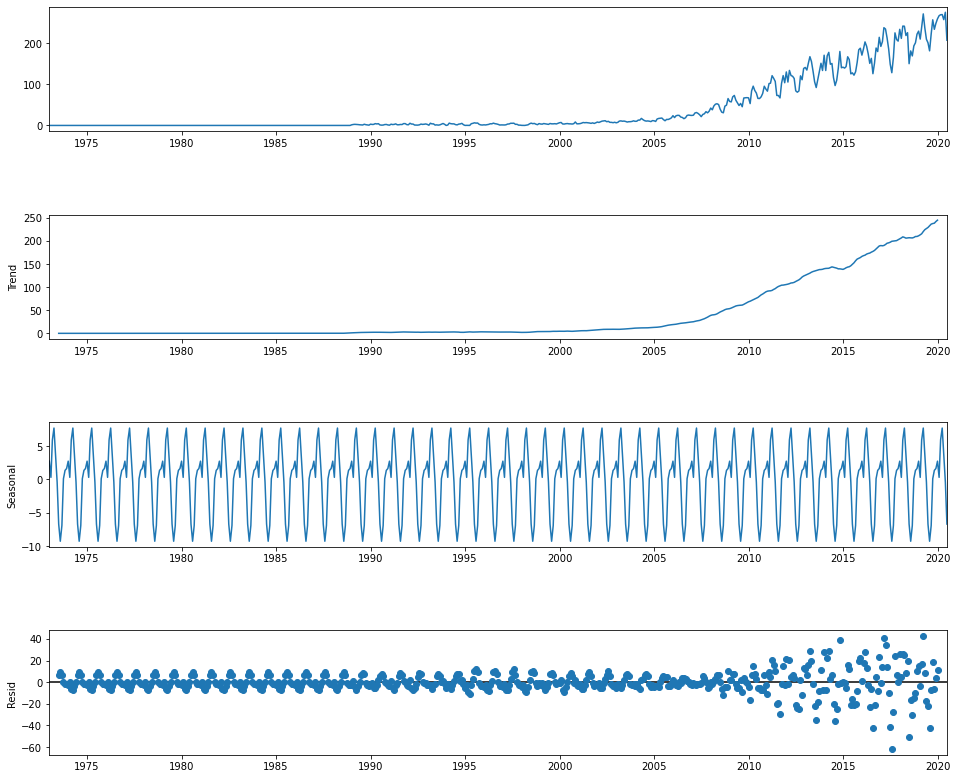

In [106]:
seasonal_decomp(df_wind)

## Selecting p,d,q

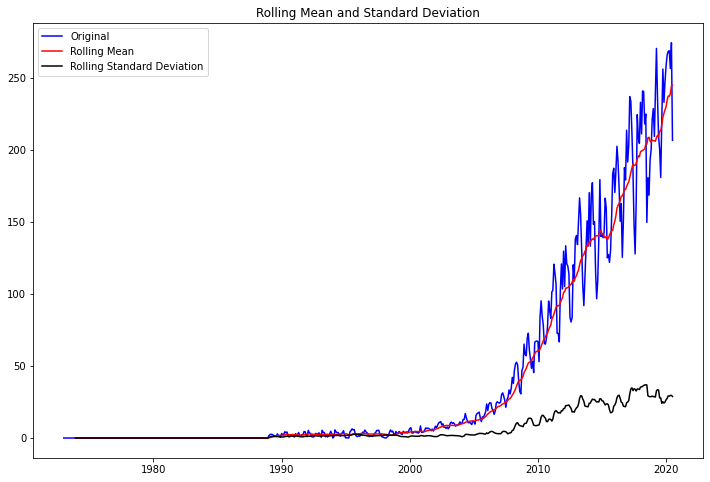

Dicky-Fuller Test:
The Series is likely Non-Stationary
Test Statistic          4.261372
p-value                 1.000000
#Lags Used             18.000000
#Observations Used    552.000000
Critical Value 1%      -3.442252
Critical Value 5%      -2.866790
Critical Value 10%     -2.569566
dtype: float64


In [107]:
test_stationarity(df_wind['Wind Energy Consumption'],12,0.05)

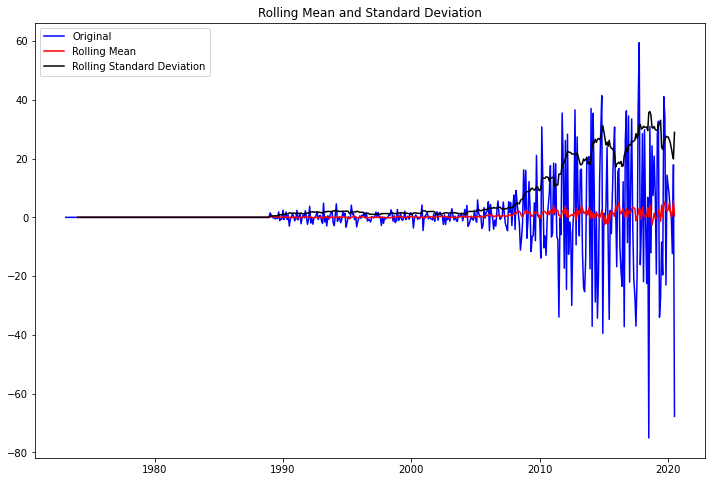

Dicky-Fuller Test:
The Series is likely Non-Stationary
Test Statistic         -2.539234
p-value                 0.106218
#Lags Used             19.000000
#Observations Used    550.000000
Critical Value 1%      -3.442296
Critical Value 5%      -2.866809
Critical Value 10%     -2.569576
dtype: float64


In [108]:
diff_1_wind = shift(df_wind['Wind Energy Consumption'],1)
test_stationarity(diff_1_wind,12,0.05)

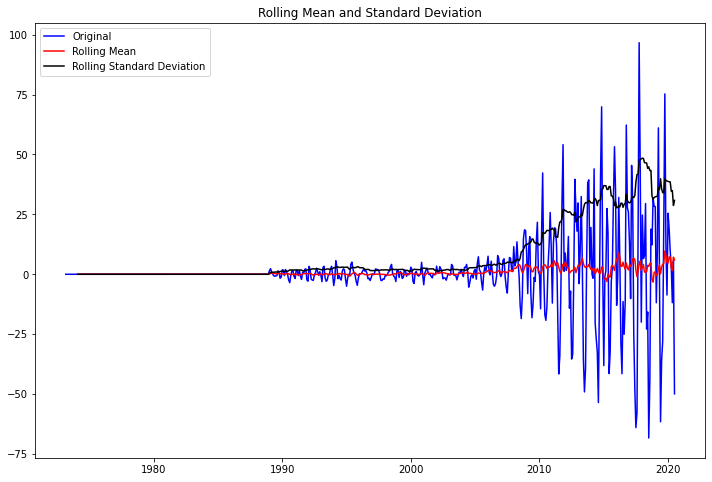

Dicky-Fuller Test:
The Series is likely Stattionary
Test Statistic         -3.444396
p-value                 0.009535
#Lags Used             19.000000
#Observations Used    549.000000
Critical Value 1%      -3.442317
Critical Value 5%      -2.866819
Critical Value 10%     -2.569582
dtype: float64


In [109]:
diff_2_wind = shift(df_wind['Wind Energy Consumption'],2)
test_stationarity(diff_2_wind,12,0.05)

<Figure size 432x288 with 0 Axes>

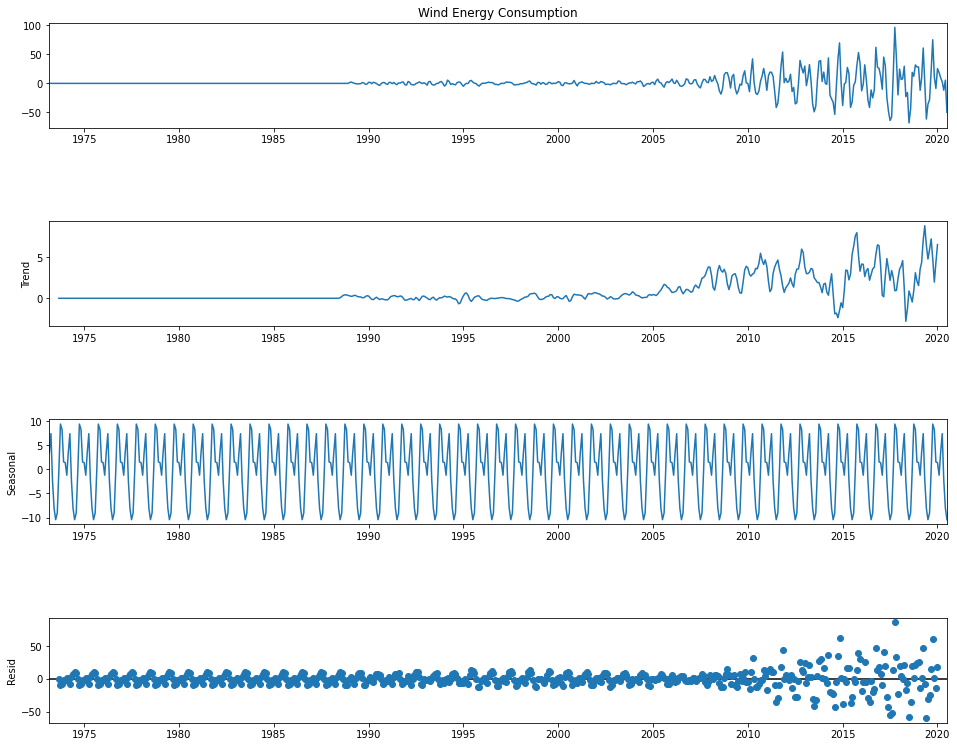

In [110]:
seasonal_decomp(diff_2_wind)

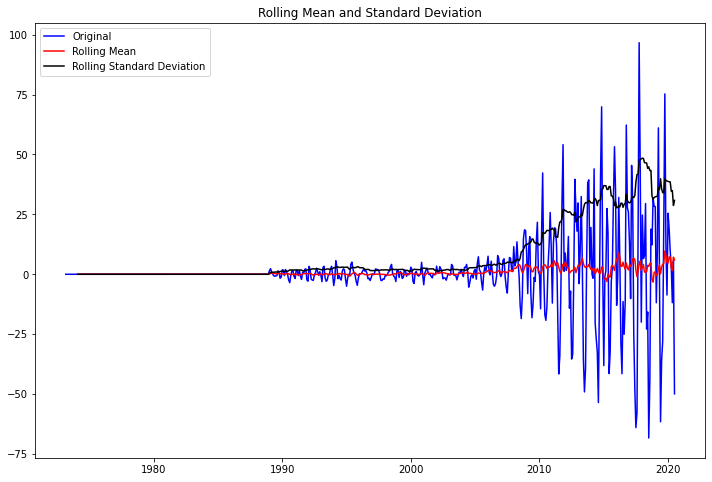

Dicky-Fuller Test:
The Series is likely Stattionary
Test Statistic         -3.444396
p-value                 0.009535
#Lags Used             19.000000
#Observations Used    549.000000
Critical Value 1%      -3.442317
Critical Value 5%      -2.866819
Critical Value 10%     -2.569582
dtype: float64


In [111]:
test_stationarity(diff_2_wind,12,0.01)

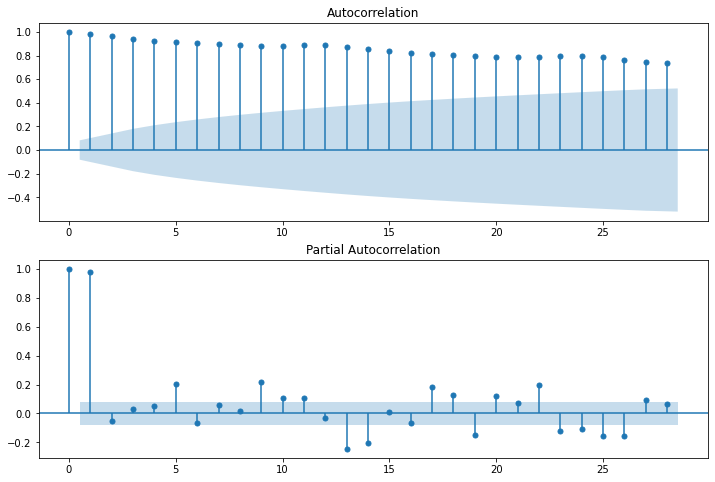

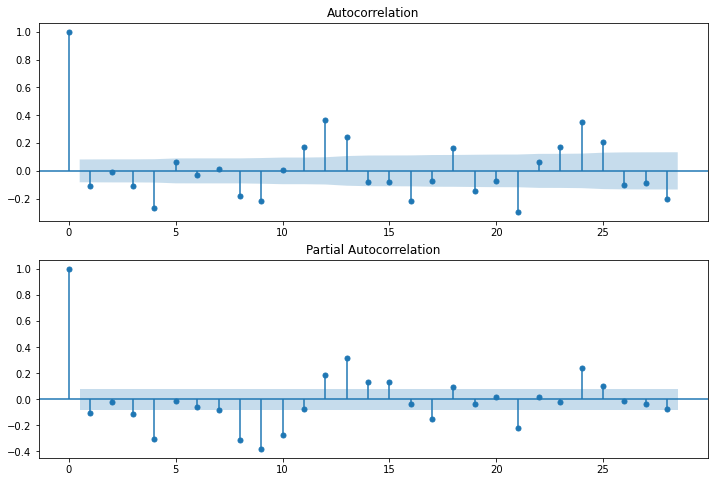

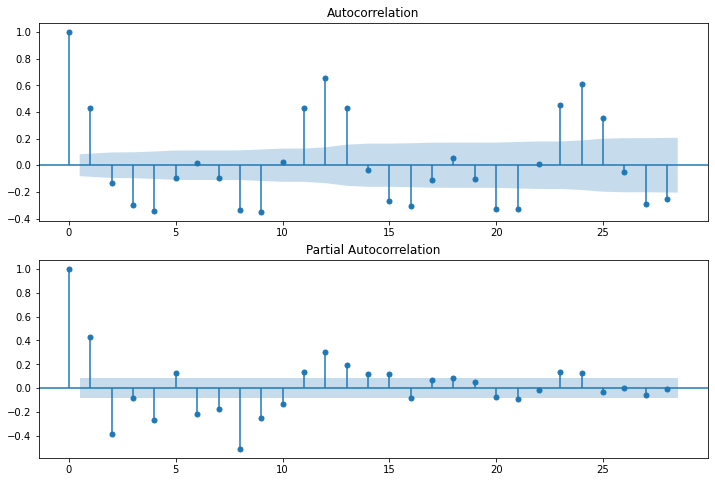

In [112]:
p_acf(df_wind)
p_acf(diff_1_wind)
p_acf(diff_2_wind)

## Base Model - Auto Arima

In [113]:
df_wind.shape[0]*0.9

513.9

In [114]:
df_wind_train,df_wind_test = df_wind[:541],df_wind[541:]

In [115]:
df_wind_test.shape

(30, 1)

FORECAST VISUALIZATION



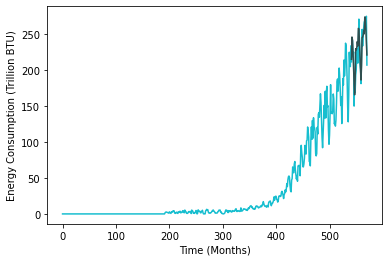



 ---------------------------------------- 

 MODEL SUMMARY 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  541
Model:             SARIMAX(4, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -1789.458
Date:                                 Sat, 09 Jan 2021   AIC                           3602.916
Time:                                         12:44:08   BIC                           3654.415
Sample:                                              0   HQIC                          3623.058
                                                 - 541                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0103      0.018      0.586      0.558      -0.024       0.045
ar.L1          0.0639      0.081      0.792      0.428      -0.094       0.222
ar.L2          0.7978      0.055     14.591      0.000       0.691       0.905
ar.L3         -0.1441      0.038     -3.746      0.000      -0.220      -0.069
ar.L4         -0.3091      0.024    -13.044      0.000      -0.356      -0.263
ma.L1         -0.7034      0.077     -9.142      0.000      -0.854      -0.553
ma.L2         -0.7798      0.034    -23.106      0.000      -0.846      -0.714
ma.L3          0.6186      0.063      9.815      0.000       0.495       0.742
ar.S.L12       0.9715      0.018     52.633      0.000       0.935       1.008
ma.S.L12      -0.5337      0.035    -15.302      0.000      -0.602      -0.465
ma.S.L24      -0.0579      0.030     -1.959      0.050      -0.116    2.93e-05
sigma2        41.6885      1.410     29.575      0.000      38.926      44.451
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              1745.28
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):             681.79   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



 ---------------------------------------- 

 MODEL PLOT DIAGNOSTICS 



 ---------------------------------------- 

 ORDER, SEASONAL ORDER 

order = (4, 1, 3)
seasonal order = (1, 0, 2, 12)


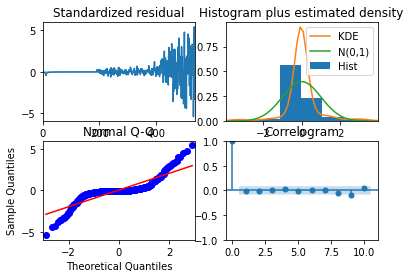

In [116]:
order_wind, seasonal_order_wind = auto_arima(df_wind,df_wind_train,df_wind_test,n_rows=541)

In [117]:
best_model_wind = arima(df_wind,order_wind,seasonal_order_wind)

C:\Users\19035\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\19035\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\19035\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4490      0.034    -42.504      0.000      -1.516      -1.382
ar.L2         -0.5392      0.063     -8.562      0.000      -0.663      -0.416
ar.L3          0.3993      0.061      6.569      0.000       0.280       0.518
ar.L4          0.1336      0.030      4.527      0.000       0.076       0.191
ma.L1          0.7647      0.022     34.151      0.000       0.721       0.809
ma.L2         -0.5144      0.033    -15.558      0.000      -0.579      -0.450
ma.L3         -0.8320      0.022    -37.479      0.000      -0.875      -0.788
ar.S.L12       1.0446      0.008    129.493      0.000       1.029       1.060
ma.S.L12      -0.8192      0.026    -31.210      0.000      -0.871      -0.768
ma.S.L24       0.1668      0.028      6.028      0.000       0.113       0.221
sigma2        57.2828      1.956     29.281      0.0

In [118]:
best_model_wind.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                 Wind Energy Consumption   No. Observations:                  571
Model:             SARIMAX(4, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -1871.606
Date:                                 Sat, 09 Jan 2021   AIC                           3765.212
Time:                                         12:44:14   BIC                           3812.460
Sample:                                     01-01-1973   HQIC                          3783.688
                                          - 07-01-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4490      0.034    -42.504      0.000      -1.516      -1.382
ar.L2         -0.5392      0.063     -8.562      0.000      -0.663      -0.416
ar.L3          0.3993      0.061      6.569      0.000       0.280       0.518
ar.L4          0.1336      0.030      4.527      0.000       0.076       0.191
ma.L1          0.7647      0.022     34.151      0.000       0.721       0.809
ma.L2         -0.5144      0.033    -15.558      0.000      -0.579      -0.450
ma.L3         -0.8320      0.022    -37.479      0.000      -0.875      -0.788
ar.S.L12       1.0446      0.008    129.493      0.000       1.029       1.060
ma.S.L12      -0.8192      0.026    -31.210      0.000      -0.871      -0.768
ma.S.L24       0.1668      0.028      6.028      0.000       0.113       0.221
sigma2        57.2828      1.956     29.281      0.000      53.449      61.117
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               537.14
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):            1252.05   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

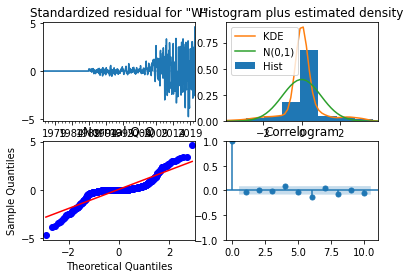

In [119]:
best_model_wind.plot_diagnostics();

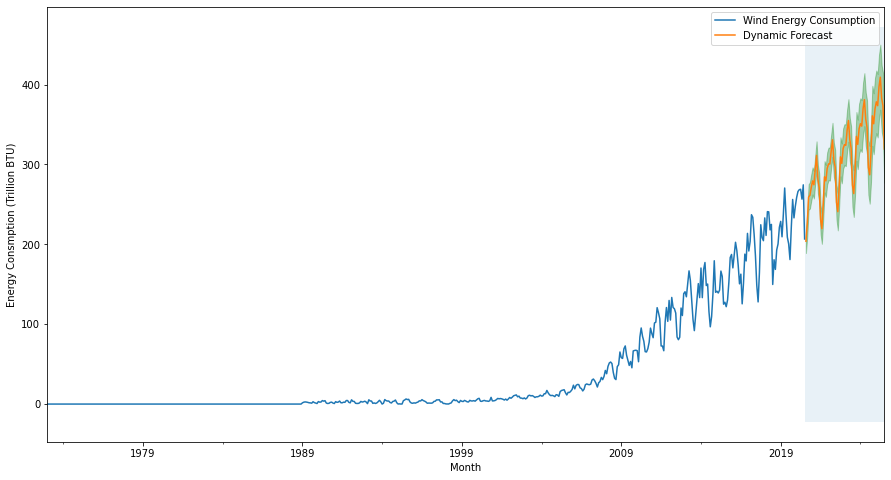

In [120]:
forecast(best_model_wind,df_wind,forecast_start=df_wind.index[-1])

# Wood Energy Consumption

## Data Exploration

In [121]:
df_wood

Wood Energy Consumption
Month                              
1973-01-01                  129.630
1973-02-01                  117.194
1973-03-01                  129.763
1973-04-01                  125.462
1973-05-01                  129.624
...                             ...
2020-03-01                  179.141
2020-04-01                  173.630
2020-05-01                  182.582
2020-06-01                  169.606
2020-07-01                  176.805

[571 rows x 1 columns]

In [122]:
df_wood.isna().sum()

Wood Energy Consumption    0
dtype: int64

<AxesSubplot:xlabel='Month'>

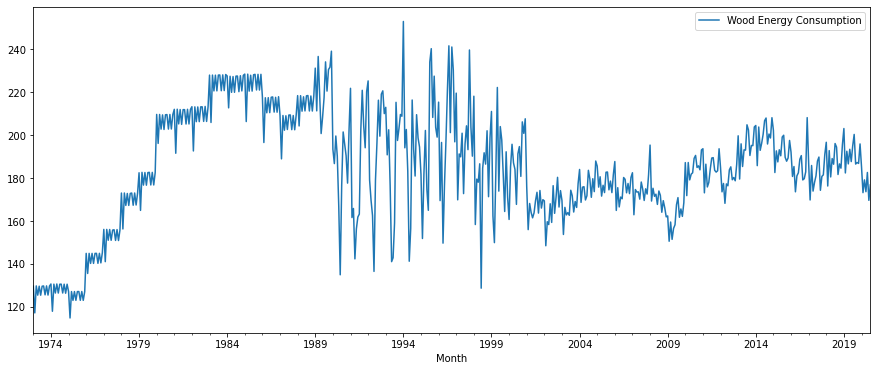

In [123]:
df_wood.plot(figsize=(15,6))

<Figure size 432x288 with 0 Axes>

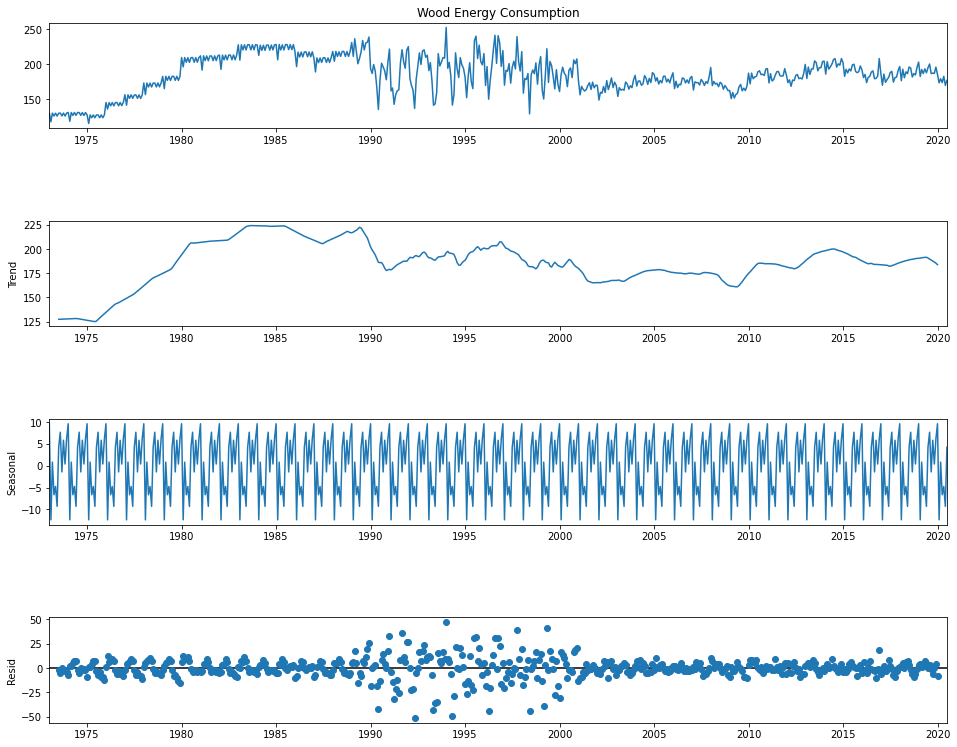

In [124]:
seasonal_decomp(df_wood['Wood Energy Consumption'])

## Selecting p,d,q

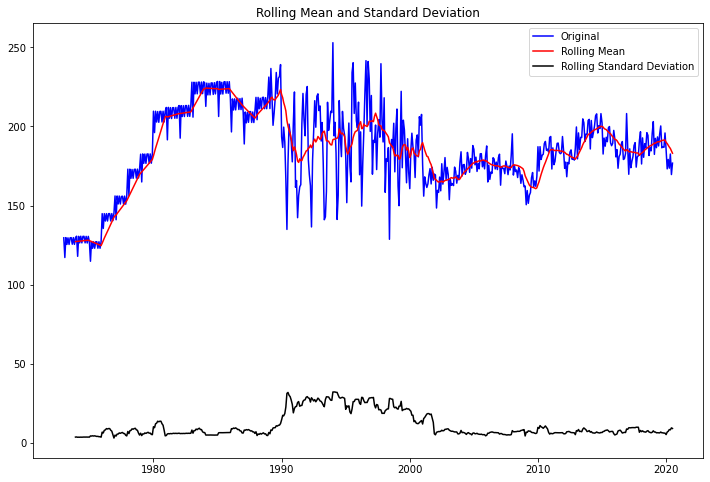

Dicky-Fuller Test:
The Series is likely Non-Stationary
Test Statistic         -2.845032
p-value                 0.052124
#Lags Used             19.000000
#Observations Used    551.000000
Critical Value 1%      -3.442274
Critical Value 5%      -2.866800
Critical Value 10%     -2.569571
dtype: float64


In [125]:
test_stationarity(df_wood['Wood Energy Consumption'],12,0.05)

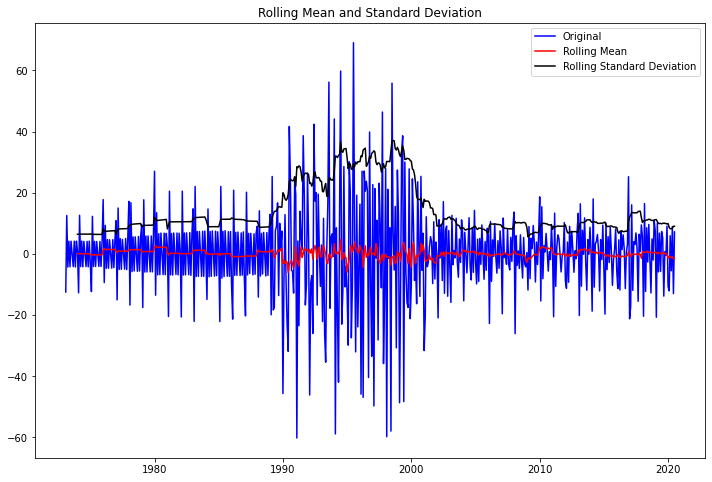

Dicky-Fuller Test:
The Series is likely Stattionary
Test Statistic         -5.598761
p-value                 0.000001
#Lags Used             18.000000
#Observations Used    551.000000
Critical Value 1%      -3.442274
Critical Value 5%      -2.866800
Critical Value 10%     -2.569571
dtype: float64


In [126]:
diff_1_wood=shift(df_wood['Wood Energy Consumption'],1)
test_stationarity(diff_1_wood,12,0.05)

<Figure size 432x288 with 0 Axes>

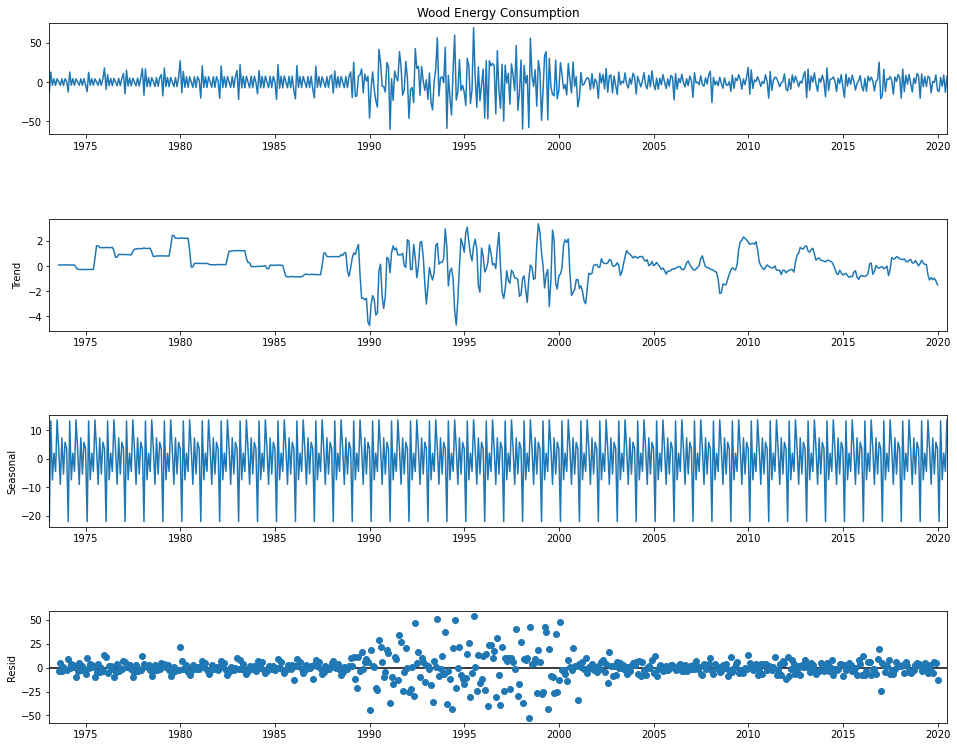

In [127]:
seasonal_decomp(diff_1_wood)

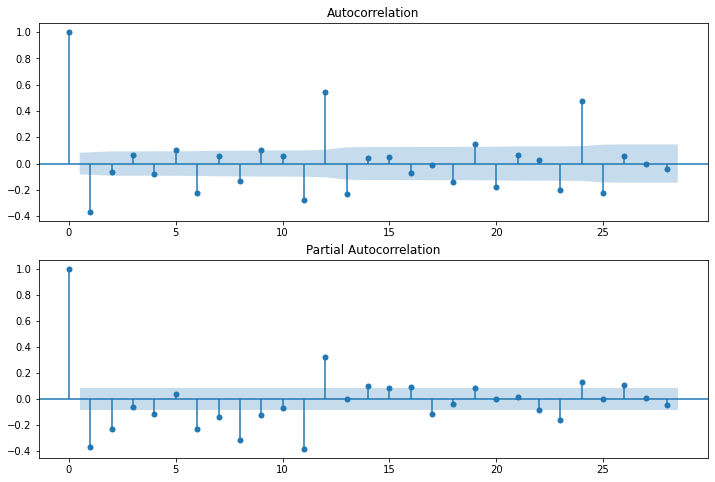

In [128]:
p_acf(diff_1_wood)

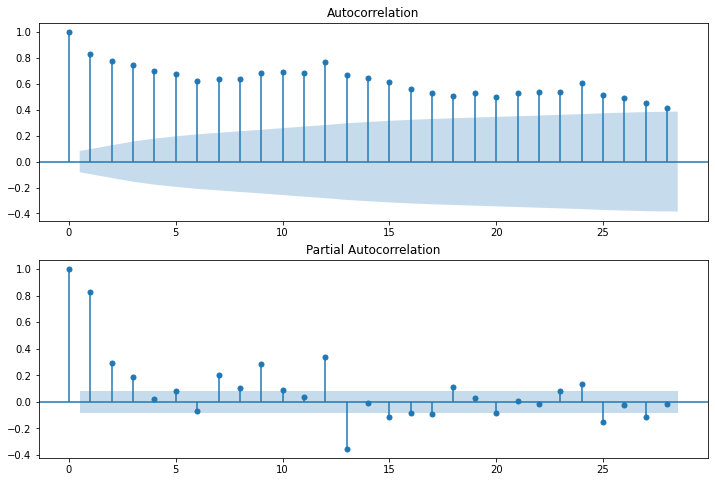

In [129]:
p_acf(df_wood['Wood Energy Consumption'])

## Slicing

In [130]:
df_wood_later = df_wood.loc['2010-01-01':]

<Figure size 432x288 with 0 Axes>

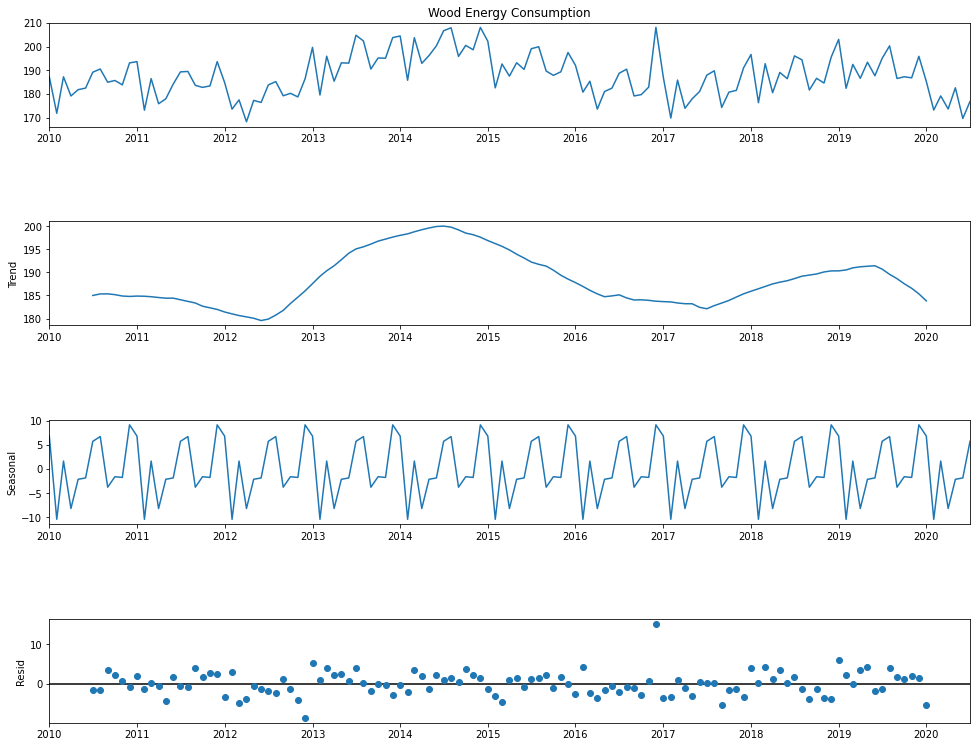

In [131]:
seasonal_decomp(df_wood_later['Wood Energy Consumption'])

In [132]:
df_wood_later.shape[0]*0.8

101.60000000000001

In [133]:
df_wood_train_ltr,df_wood_test_ltr = df_wood_later[:102],df_wood_later[102:]

## Auto Arima Model

C:\Users\19035\AppData\Roaming\Python\Python36\site-packages\pmdarima\arima\utils.py:120: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (42) is shorter than m (60). Using D=1
  % (len(x), m, D))


FORECAST VISUALIZATION



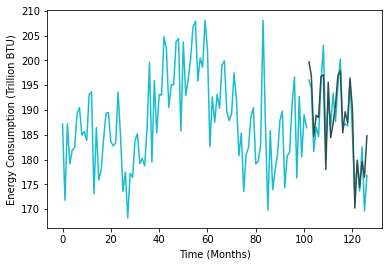



 ---------------------------------------- 

 MODEL SUMMARY 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 60)   Log Likelihood                -119.209
Date:                             Sat, 09 Jan 2021   AIC                            244.418
Time:                                     12:44:52   BIC                            249.559
Sample:                                          0   HQIC                           246.290
                                             - 102                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3851      0.255     -1.512      0.131      -0.884       0.114
ma.L1         -0.7342      0.150     -4.887      0.000      -1.029      -0.440
sigma2        19.2644      3.376      5.707      0.000      12.648      25.881
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.62
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.42
Prob(H) (two-sided):                  0.68   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



 ---------------------------------------- 

 MODEL PLOT DIAGNOSTICS 



 ---------------------------------------- 

 ORDER, SEASONAL ORDER 

order = (0, 1, 1)
seasonal order = (0, 1, 0, 60)


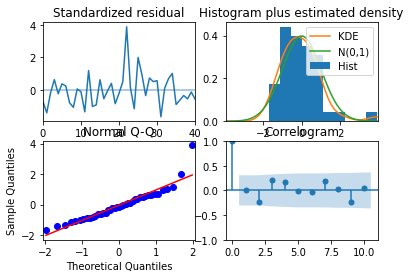

In [134]:
order_wood, seasonal_order_wood = auto_arima(df_wood_later,df_wood_train_ltr,df_wood_test_ltr,n_rows=102,m=60)

In [135]:
best_model_wood = arima(df_wood_later,order_wood,seasonal_order_wood)

C:\Users\19035\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\19035\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6253      0.130     -4.815      0.000      -0.880      -0.371
sigma2        19.0275      2.650      7.182      0.000      13.835      24.220


In [136]:
best_model_wood.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Wood Energy Consumption   No. Observations:                  127
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 60)   Log Likelihood                -185.111
Date:                             Sat, 09 Jan 2021   AIC                            374.223
Time:                                     12:44:52   BIC                            378.541
Sample:                                 01-01-2010   HQIC                           375.924
                                      - 07-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6253      0.130     -4.815      0.000      -0.880      -0.371
sigma2        19.0275      2.650      7.182      0.000      13.835      24.220
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                31.10
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.99
Prob(H) (two-sided):                  0.62   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

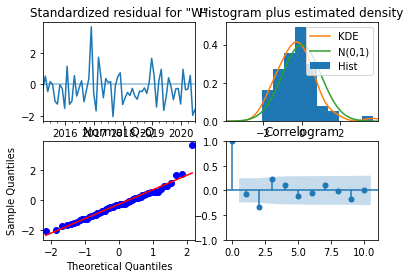

In [137]:
best_model_wood.plot_diagnostics();

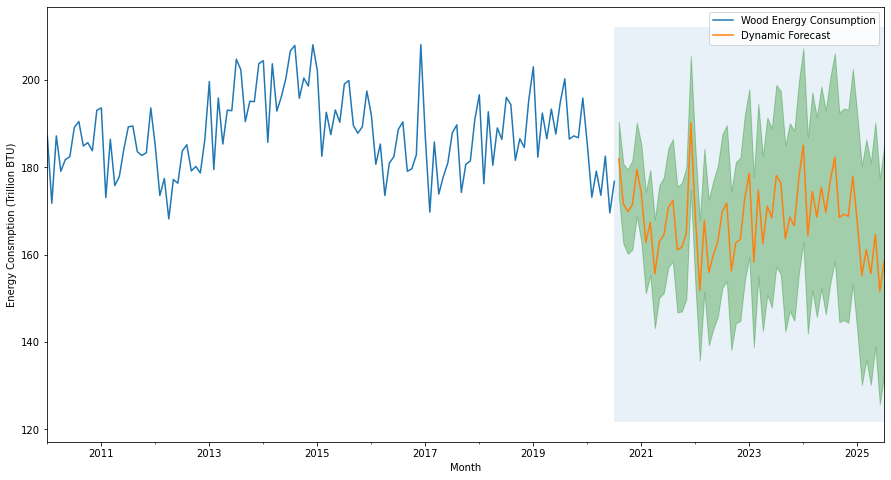

In [138]:
forecast(best_model_wood,df_wood_later,forecast_start=df_wood_later.index[-1])

# Comparison

Comparing the 5 year predictions for energy consumption aids deciding the sector to invest in.

**Visualizing Forecasts**

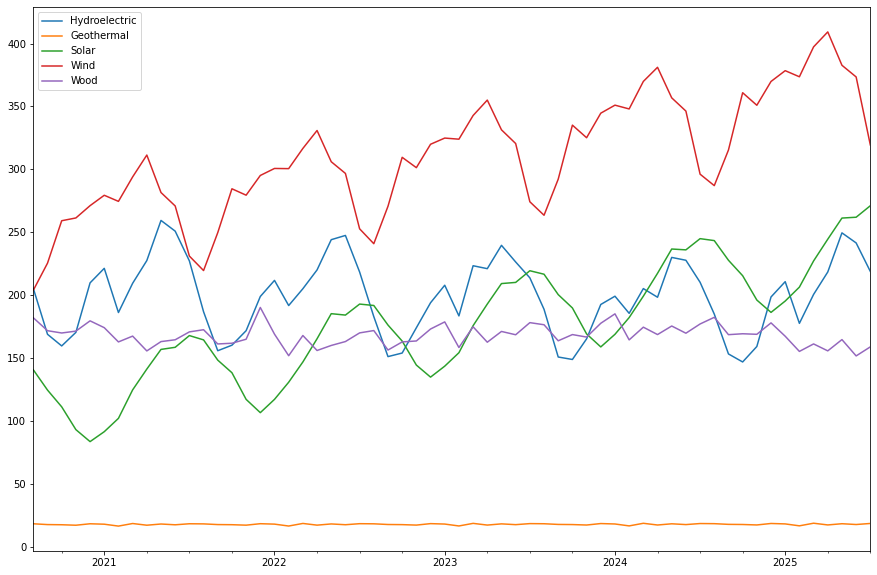

In [139]:
forecast_hyele = best_model.get_forecast(steps=60)
forecast_geo = best_model_geo.get_forecast(steps=60)
forecast_solar = best_model_solar.get_forecast(steps=60)
forecast_wind = best_model_wind.get_forecast(steps=60)
forecast_wood= best_model_wood.get_forecast(steps=60)

plt.figure(figsize=(15,10),)
ax = plt.axes()
# df_geo_later['2020':].plot(ax=ax)
# df_solar['2020':].plot(ax=ax)
# df_wind['2020':].plot(ax=ax)
# df_wood_later['2020':].plot(ax=ax)
forecast_hyele.predicted_mean.plot(label='Hydroelectric', ax=ax)
forecast_geo.predicted_mean.plot(label='Geothermal',ax=ax)
forecast_solar.predicted_mean.plot(label='Solar',ax=ax)
forecast_wind.predicted_mean.plot(label='Wind',ax=ax)
forecast_wood.predicted_mean.plot(label='Wood',ax=ax)

plt.legend()
plt.show()

**Visualizing trend since 1990, including the predictions**

In [140]:
forecasts = pd.concat([pd.DataFrame(forecast_5.predicted_mean).rename(columns={'predicted_mean':'Hydroelectric Power Consumption'}),
                       pd.DataFrame(forecast_geo.predicted_mean).rename(columns={'predicted_mean':'Geothermal Energy Consumption'}),
                       pd.DataFrame(forecast_solar.predicted_mean).rename(columns={'predicted_mean':'Solar Energy Consumption'}),
                       pd.DataFrame(forecast_wind.predicted_mean).rename(columns={'predicted_mean':'Wind Energy Consumption'}),
                       pd.DataFrame(forecast_wood.predicted_mean).rename(columns={'predicted_mean':'Wood Energy Consumption'})],axis=1)
forecasts

Hydroelectric Power Consumption  Geothermal Energy Consumption  \
2020-08-01                       205.266494                      18.223181   
2020-09-01                       168.853255                      17.590660   
2020-10-01                       159.596314                      17.454178   
2020-11-01                       170.378228                      17.079773   
2020-12-01                       209.729841                      18.231026   
2021-01-01                       221.277996                      17.888066   
2021-02-01                       186.152780                      16.386983   
2021-03-01                       209.384287                      18.432010   
2021-04-01                       227.454583                      17.088981   
2021-05-01                       259.357687                      18.036854   
2021-06-01                       250.838328                      17.419071   
2021-07-01                       227.204829                      18.238396   
2021-08-01                       186.771850                      18.138526   
2021-09-01                       155.788709                      17.594372   
2021-10-01                       160.176813                      17.490502   
2021-11-01                       171.714447                      17.126668   
2021-12-01                       198.892995                      18.287024   
2022-01-01                       211.695220                      17.944276   
2022-02-01                       191.704872                      16.437662   
2022-03-01                       205.069223                      18.491238   
2022-04-01                       220.014993                      17.142814   
2022-05-01                       244.056836                      18.094577   
2022-06-01                       247.423504                      17.474287   
2022-07-01                       218.373696                      18.296955   
2022-08-01                       182.890186                      18.196680   
2022-09-01                       151.115224                      17.650309   
2022-10-01                       153.952712                      17.546015   
2022-11-01                       174.046095                      17.180699   
2022-12-01                       193.915355                      18.345784   
2023-01-01                       207.847215                      18.001638   
2023-02-01                       183.461045                      16.488885   
2023-03-01                       223.343377                      18.550829   
2023-04-01                       221.013979                      17.196910   
2023-05-01                       239.566215                      18.152552   
2023-06-01                       226.337211                      17.529734   
2023-07-01                       213.726665                      18.355755   
2023-08-01                       188.714253                      18.255071   
2023-09-01                       150.792212                      17.706474   
2023-10-01                       148.831232                      17.601755   
2023-11-01                       165.225355                      17.234950   
2023-12-01                       192.558407                      18.404783   
2024-01-01                       199.123451                      18.059235   
2024-02-01                       185.504236                      16.540317   
2024-03-01                       205.181484                      18.610664   
2024-04-01                       198.301663                      17.251227   
2024-05-01                       229.953463                      18.210764   
2024-06-01                       227.695303                      17.585408   
2024-07-01                       210.197818                      18.414795   
2024-08-01                       184.910132                      18.313700   
2024-09-01                       153.232529                      17.762867   
2024-10-01                       1

In [141]:
df2 = df1[['Hydroelectric Power Consumption','Geothermal Energy Consumption','Solar Energy Consumption',
   'Wind Energy Consumption','Wood Energy Consumption']]

In [142]:
df_full = pd.concat([df2,forecasts],axis=0)

Text(0.5, 1.0, 'Energy Consumption 1990-2025')

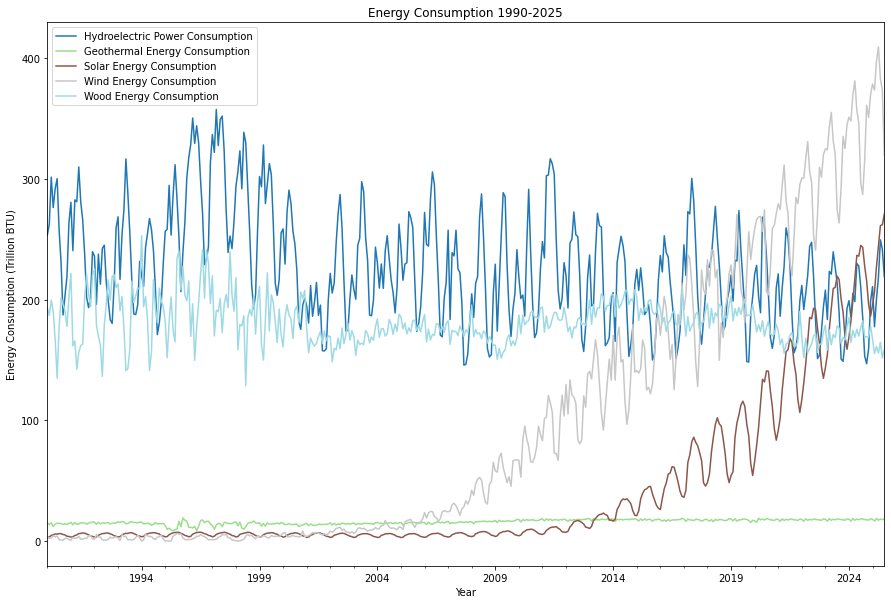

In [143]:
df_full['1990':].plot(figsize=(15,10),colormap='tab20')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (Trillion BTU)')
plt.title('Energy Consumption 1990-2025')

**Visualizing trend since 1990, including the predictions (Rolling Mean for better visualization)**

Text(0.5, 1.0, 'Energy Consumption 1990-2025')

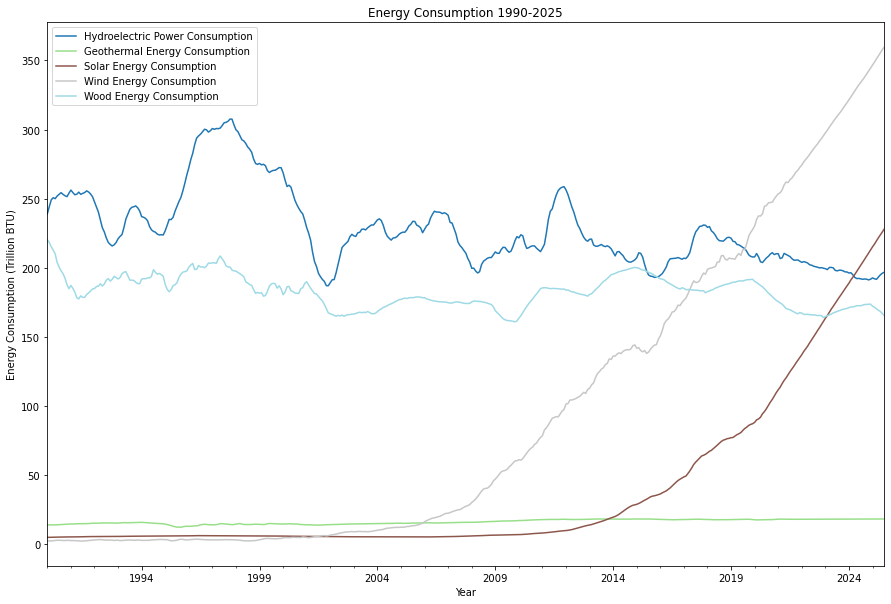

In [144]:
rm_hyele = df_full['Hydroelectric Power Consumption'].rolling(12).mean()
rm_geo = df_full['Geothermal Energy Consumption'].rolling(12).mean()
rm_solar = df_full['Solar Energy Consumption'].rolling(12).mean()
rm_wind = df_full['Wind Energy Consumption'].rolling(12).mean()
rm_wood = df_full['Wood Energy Consumption'].rolling(12).mean()

rm=pd.concat([rm_hyele,rm_geo,rm_solar,rm_wind,rm_wood],axis=1)

rm['1990':].plot(figsize=(15,10),colormap='tab20')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (Trillion BTU)')
plt.title('Energy Consumption 1990-2025')

# Conclusion

Current Trend:
- All energy consumption trends show seasonal variations per month.
- Current trends show that Hydroelectric Power Consumption has been dominating the market for decades now.
- Solar and Wind Energy Consumption is rising exponentially and shows promising growth and opportunities
- Geothermal energy consumption is almost stagnant with continuing to grow with only a minimum margin.
- Wood energy consumption has also been stagnant but significant, with numbers only a little less than Hydroelectric Power consumption. Both these sources have plateaued over time and continue the same trend with no significant growth over time.

Forecast:
- Geothermal Energy, Wood Energy, and Hydroelectric Power Consumption is predicted to remain stagnant or show minimal growth around the plateaued values.
- Solar and Wind Energy Consumptions continue to rise significantly surpassing the values of Hydroelectric Power and Wood Energy consumptions.
- Due to seasonality, during few months, consumption for these may cross over for a brief moment should the forecast be extended a few years down the line.
- The slope of increase for these consumptions are almost parallel with solar demonstrating a slightly steeper slope, indicating an overlap in the future years. 

Based on research and the current market, there has been enormous growth in Solar Energy Production. For a clear recommendation it is therefore important to analyze and take into consideration the demand (consumption), supply (Production), cost of production, and the price of the energy source before making any investment decision.

# Recommendations

Based on the type of investment that an investor wishes to make, below are a few recommendations following this time series analysis:
- Looking at the forecasts, investors looking for mid term investments should look into investing in wind farms since it has tremendous opportunities and seen to grow and exceed the consumptions of all other energy sources.
- For short term investments, the investors should take into consideration the seasonal variations which is common to all energy sources. These investors should look into investing in Wind Energy, since in the consumption rates for Wind would cross over those of Hydroelectric power in the later half of 2020.
- Long term investors are strongly recommended to look into the market trends for Energy production in solar and wind. Since there has been tremendous growth and promotion of solar farms and residential/commercial solar projects, the trend is likely to increase the slope of solar energy consumption with it crossing over wind energy consumption sooner than later.

# Future Work

- Conduct a time series analysis for production, cost and returns related to each source of renewable energy for a better insights into the investing opportunities
- Build an interactive dashboard as a tool for the investors to recommend the best source of energy to invest in based on the amount and period of investment. This tool will take into consideration all four aspects, Demand, Supply, Cost and Returns to recommend the most profitable sector to invest in.